In [64]:
import requests
from requests.auth import HTTPBasicAuth
import astropy.table as at
import matplotlib
from matplotlib.transforms import Bbox
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import astropy.units as u
from astropy.visualization import PercentileInterval, AsinhStretch
from astroquery.mast import Catalogs
from astroquery.sdss import SDSS
from astroquery.simbad import Simbad

import os
import sys
import shutil
import glob
import json

import warnings
warnings.filterwarnings("ignore")


In [39]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA


import antares_client

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [60]:
def panstarrs_image_filename(position,image_size=None, filter=None):
    """Query panstarrs service to get a list of image names
    Parameters
    ----------
    :position : :class:`~astropy.coordinates.SkyCoord`
        Target centre position of the cutout image to be downloaded.
    :size : int: cutout image size in pixels.
    :filter: str: Panstarrs filter (g r i z y)
    Returns
    -------
    :filename: str: file name of the cutout
    """

    service = 'https://ps1images.stsci.edu/cgi-bin/ps1filenames.py'
    url = (f'{service}?ra={position.ra.degree}&dec={position.dec.degree}'
           f'&size={image_size}&format=fits&filters={filter}')

    filename_table = pd.read_csv(url, delim_whitespace=True)['filename']
    return filename_table[0] if len(filename_table) > 0 else None

    
def panstarrs_cutout(position, filename, image_size=None, filter=None):
    """
    Download Panstarrs cutout from their own service
    Parameters
    ----------
    :position : :class:`~astropy.coordinates.SkyCoord`
        Target centre position of the cutout image to be downloaded.
    :image_size: int: size of cutout image in pixels
    :filter: str: Panstarrs filter (g r i z y)
    Returns
    -------
    :cutout : :class:`~astropy.io.fits.HDUList` or None
    """
    
    if filename:
        service = 'https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?'
        fits_url = (f'{service}ra={position.ra.degree}&dec={position.dec.degree}'
                    f'&size={image_size}&format=fits&red={filename}')
        fits_image = fits.open(fits_url)
    else:
        fits_image = None

    return fits_image

In [69]:
def host_pdfs(df,imsizepix=100,change_contrast=False):
        
        # let's make a PDF with all the host gal coords
        # so we can look through by eye and see which ones

        ref_name = df.name[0]
        data = df
        
        pdf_pages = PdfPages(f'../figures/{ref_name}_host_thumbnails.pdf')

        for i, d in df.iterrows():
            
            stamp_path = f"../ps1_cutouts/{d['name']}_pscutout.fits"
            if os.path.isfile(stamp_path): 
                #print(f"Remove previously saved cutout {d['name']}_pscutout.fits to download new one")
                os.remove(stamp_path)
            
            #if i > 20: break
            if not i % 9:
                fig = plt.figure(figsize=(6,6))
                
            #fig = plt.figure()
            
            ax = plt.subplot(3,3,i%9+1)

            ax.set_xticks([])
            ax.set_yticks([])

            # download the PS image
            sc = SkyCoord(d['ra'],d['dec'],unit=u.deg)

            outfilename = f"../ps1_cutouts/{d['name']}_pscutout.fits"
            if not os.path.exists(outfilename):
                filename = panstarrs_image_filename(sc,image_size=imsizepix,filter='r')
                fits_image = panstarrs_cutout(sc,filename,image_size=imsizepix,filter='r')
                fits_image.writeto(outfilename)
                
            wcs = WCS(f"../ps1_cutouts/{d['name']}_pscutout.fits")

            imdata = fits.getdata(f"../ps1_cutouts/{d['name']}_pscutout.fits")

            if change_contrast==True:
                transform = AsinhStretch() + PercentileInterval(93)
            
            else: transform = AsinhStretch() + PercentileInterval(99.5)
            bfim = transform(imdata)
            ax.imshow(bfim,cmap="gray",origin="lower")
            #ax.plot(imsizepix/2,imsizepix/2,'+',color='r',ms=15)
                
            ax.set_title(f"{d['name']}",pad=1, fontsize=14)

            if i % 9 == 8:
                plt.ion()
                plt.show()
                #plt.subplots_adjust(0,0,1,1,-0.05,0.05)
                pdf_pages.savefig(fig, bbox_inches='tight', pad_inches=0.1)
                plt.close()
         
        pdf_pages.close()
        plt.show()
        

In [10]:
class AnnoyIndex():
    def __init__(self, vectors, labels, metric):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
        self.metric= metric
   
    def build(self, number_of_trees=100):
        self.index = annoy.AnnoyIndex(self.dimension, self.metric)
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=1000):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=-1)                                           
        return [self.labels[i] for i in indices]
    
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         'feature_linear_trend_magn_r',
                         'feature_linear_trend_sigma_magn_r',
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         'feature_period_s_to_n_0_magn_r',
                         #'feature_period_1_magn_r', 
                         'feature_period_s_to_n_1_magn_r',
                         #'feature_period_2_magn_r', 
                         'feature_period_s_to_n_2_magn_r',
                         #'feature_period_3_magn_r', 
                         'feature_period_s_to_n_3_magn_r',
                         #'feature_period_4_magn_r', 
                         'feature_period_s_to_n_4_magn_r',
                         #'feature_periodogram_amplitude_magn_r',
                         'feature_periodogram_beyond_2_std_magn_r',
                         'feature_periodogram_beyond_3_std_magn_r',
                         'feature_periodogram_standard_deviation_magn_r', 
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         'feature_linear_trend_magn_g',
                         'feature_linear_trend_sigma_magn_g',
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         'feature_period_s_to_n_0_magn_g',
                         #'feature_period_1_magn_g', 
                         'feature_period_s_to_n_1_magn_g',
                         #'feature_period_2_magn_g', 
                         'feature_period_s_to_n_2_magn_g',
                         #'feature_period_3_magn_g', 
                         'feature_period_s_to_n_3_magn_g',
                         #'feature_period_4_magn_g', 
                         'feature_period_s_to_n_4_magn_g',
                         #'feature_periodogram_amplitude_magn_g',
                         'feature_periodogram_beyond_2_std_magn_g',
                         'feature_periodogram_beyond_3_std_magn_g',
                         'feature_periodogram_standard_deviation_magn_g', 
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
#   'zmomentXX',
#  'zmomentXY',
#  'zmomentYY',
#  'zmomentR1',
#  'zmomentRH',
#  'zPSFFlux',
# #  'zPSFFluxErr',
#  'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
#  'zKronFlux',
# #  'zKronFluxErr',
#  'zKronRad',
# #  'zexpTime',
#   'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
#   'ymomentXX',
#   'ymomentXY',
#   'ymomentYY',
#   'ymomentR1',
#   'ymomentRH',
#   'yPSFFlux',
# #   'yPSFFluxErr',
#   'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
#  'yKronFlux',
# #  'yKronFluxErr',
#  'yKronRad',
# #  'yexpTime',
#   'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
#    'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
#  'zApMag_zKronMag',
#  'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

lc_and_host_features = feature_names_r_g+feature_names_hostgal

In [11]:
# dataset was created by dropping 'sdss_stars', 'asassn_variable_catalog', 'asassn_variable_catalog_v2_20190802', 'veron_agn_qso'
# 'bright_guide_star_cat' is sometimes a galaxy, so keep
dataset_bank_90k = pd.read_csv('../loci_dbs/loci_df_271688objects_cut_stars_and_gal_plane_transf.csv', 
                                   compression='gzip',
                                   usecols=lambda c: c in ztf_id_and_features_r_g,)
                                  #)
        
# drop row if any feature values are nan
dataset_bank_90k = dataset_bank_90k[~dataset_bank_90k[feature_names_r_g].isnull().any(axis=1)]

#mask = (dataset_bank['num_mag_values'] >= 40) #& (dataset_bank['num_mag_values'] <= 40)
#dataset_bank = dataset_bank[mask]
dataset_bank_90k.drop_duplicates(subset="ztf_object_id", keep='first', inplace=True)
dataset_bank_90k = dataset_bank_90k.set_index('ztf_object_id')
dataset_bank_90k.index.rename("TransientName", inplace=True)
dataset_bank_90k

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (7,125,129,130,131,132,133,134) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,locus_id,ra,dec,tags,catalogs,ztf_ssnamenr,num_alerts,num_mag_values,oldest_alert_id,...,anom_score,anomaly_score,anomaly_mask,anomaly_type,is_corrected,vpdf_extreme_version,vpdf_extreme_faint,vpdf_extreme_bright,locus_gal_l,locus_gal_b
TransientName,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,6,ANT2020rajqu,33.976088,-20.258905,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,137,35,ztf_candidate:993481181415010007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197.881532,-69.513571
ZTF18acfvwwa,39,ANT2020pc6ko,35.639509,32.833982,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,659,88,ztf_candidate:943483942915015010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.200342,-26.246909
ZTF17aaaskvj,58,ANT2020rdpmm,28.015003,36.953217,['lc_feature_extractor'],"['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...",NaN,1497,579,ztf_candidate:598425334815010002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.189482,-24.352953
ZTF18aczbnhl,97,ANT2019dsk24,85.049145,-11.013302,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,105,12,ztf_candidate:718232301815010005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214.961559,-20.751422
ZTF18actbhqt,98,ANT202066j3s,75.082443,-11.302676,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,89,14,ztf_candidate:702289832715010026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210.690974,-29.741520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18adairvu,999924,ANT2020ro626,84.348727,-2.927551,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,96,10,ztf_candidate:722282332515010003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.956641,-17.786773
ZTF20aaiwhct,999926,ANT2020pxghw,64.146691,-1.656598,"['dimmers', 'lc_feature_extractor']","['gaia_dr2', 'bright_guide_star_cat', 'allwise']",NaN,86,35,ztf_candidate:1113204944015010026,...,NaN,NaN,NaN,TBD,NaN,NaN,NaN,NaN,194.540371,-34.719753
ZTF20aberawv,999927,ANT2020aebbk,292.910293,54.078978,"['lc_feature_extractor', 'dimmers']",[],NaN,235,96,ztf_candidate:1231482062015010023,...,NaN,0.417276,Fail,TBD,NaN,NaN,NaN,NaN,85.961850,16.149525


In [12]:
%%time

# Instead of above, read in from csv files with host gal info!
# Visually vetted GHOST results split up over XXX files
# So merge them

dfs = []
for start_idx, end_idx in zip(range(0, 72100, 100), range(100, 72200, 100)): #90199, 90299
    df = pd.read_csv(f'./host_info/dataset_bank_hosts_start_idx:end_idx={start_idx}:{end_idx}.csv')
    dfs.append(df)
    
g_hosts_df = pd.concat(dfs, axis=0).reset_index(drop=True)
g_hosts_df.drop_duplicates(subset="TransientName", keep='first', inplace=True)
g_hosts_df = g_hosts_df.set_index('TransientName')
g_hosts_df.sort_values('TransientName', inplace=True)
#g_hosts_df.reset_index(inplace=True, drop=True)
g_hosts_df

CPU times: user 13.5 s, sys: 762 ms, total: 14.2 s
Wall time: 14.7 s


,objName,objAltName1,objAltName2,objAltName3,objID,uniquePspsOBid,ippObjID,surveyID,htmID,zoneID,...,primaryDetection_y,gpetR90,rpetR90,ipetR90,zpetR90,ypetR90,NED_redshift_flag,hasSimbad,class,level_0
TransientName,,,,,,,,,,,,,,,,,,,,,
AT2019ye,PSO J135804.487+203809.056,NaN,NaN,NaN,132762095186853570,916270000024592,143378893266959,0,14931762990582,13276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PS18acw,PSO J203708.962-044523.671,NaN,NaN,NaN,102293092873892523,1049658000060517,397026776902759,0,12246887638605,10229,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PS18kz,PSO J132531.079-142122.461,NaN,NaN,NaN,90772013794782874,1040248000047767,422246824852118,0,11265143992289,9077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SDSS-IISN17461,PSO J034305.548+001507.550,NaN,NaN,NaN,107690557731417905,943938000022176,365716465276576,0,9423182795338,10769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SN2016ezh,PSO J015804.744+005221.791,NaN,NaN,NaN,106950295197783171,927303000104953,363457312561658,0,8961418540888,10695,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acqetxn,PSO J235011.541+191045.231,NaN,NaN,NaN,131013575480825509,1076778000026511,161254547154832,0,13215295323352,13101,...,1.0,11.96380,5.68306,3.76124,3.02015,NaN,NaN,0.0,NaN,NaN
ZTF21acqnurt,PSO J223925.671-022448.679,NaN,NaN,NaN,105103398569764184,1076249000094978,400995326718721,0,12661889120003,10510,...,1.0,15.28430,2.52730,1.53292,1.24170,2.55906,NaN,0.0,False,NaN
ZTF21acqoloi,PSO J231829.296-011726.224,NaN,NaN,NaN,106453496221281681,1082715000043887,401837140257649,0,12704687240487,10645,...,1.0,NaN,9.90200,2.44196,1.46597,3.27679,NaN,0.0,NaN,NaN


In [13]:
len(np.unique(g_hosts_df.index))

19503

In [14]:
# merge ghost info and databank info

# rename as dataset_bank
dataset_bank = pd.merge(dataset_bank_90k, g_hosts_df, left_index=True, right_index=True, how='inner')
dataset_bank.index.rename("ztf_object_id", inplace=True)
dataset_bank.to_csv('../dataframes/dataset_bank.csv')
dataset_bank

,Unnamed: 0,locus_id,ra,dec,tags,catalogs,ztf_ssnamenr,num_alerts,num_mag_values,oldest_alert_id,...,primaryDetection_y,gpetR90,rpetR90,ipetR90,zpetR90,ypetR90,NED_redshift_flag,hasSimbad,class,level_0
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,6,ANT2020rajqu,33.976088,-20.258905,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,137,35,ztf_candidate:993481181415010007,...,1.0,6.10360,4.04109,1.675730,3.49369,29.580500,NaN,0.0,False,NaN
ZTF18acfvwwa,39,ANT2020pc6ko,35.639509,32.833982,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,659,88,ztf_candidate:943483942915015010,...,1.0,7.05256,1.08888,1.214940,3.95098,1.729270,NaN,0.0,False,NaN
ZTF17aaaskvj,58,ANT2020rdpmm,28.015003,36.953217,['lc_feature_extractor'],"['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...",NaN,1497,579,ztf_candidate:598425334815010002,...,1.0,3.99288,1.86034,0.730485,1.92726,1.964520,NaN,0.0,NaN,NaN
ZTF18actbhqt,98,ANT202066j3s,75.082443,-11.302676,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,89,14,ztf_candidate:702289832715010026,...,1.0,NaN,NaN,2.092530,NaN,NaN,NaN,1.0,NaN,NaN
ZTF20aciscxz,100,ANT2020aegc7vi,83.973369,-9.123083,"['lc_feature_extractor', 'high_flux_ratio_wrt_...","['allwise', 'bright_guide_star_cat']",NaN,48,18,ztf_candidate:1356481843915015002,...,1.0,1.05484,1.57786,1.876240,0.98579,1.653290,NaN,0.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18abryurz,817061,ANT2018ghiok,34.680416,29.468295,"['lc_feature_extractor', 'iso_forest_anomaly_d...","['allwise', 'bright_guide_star_cat', '2mass_ps...",NaN,175,9,ztf_candidate:606442754815010556,...,1.0,19.66100,1.96626,2.224410,2.97030,3.066260,NaN,0.0,False,NaN
ZTF18aaokokk,817217,ANT2018jiu2s,273.808976,55.969289,['lc_feature_extractor'],"['gaia_dr2', 'bright_guide_star_cat', '2mass_p...",NaN,267,48,ztf_candidate:569411894515010003,...,1.0,18.39890,1.71872,1.426280,2.42323,12.396400,NaN,0.0,False,NaN
ZTF18ackjnby,817218,ANT2020djewm,311.587364,79.904392,"['lc_feature_extractor', 'iso_forest_anomaly_d...","['bright_guide_star_cat', '2mass_psc', 'allwis...",NaN,490,12,ztf_candidate:941293684915015048,...,1.0,19.90590,1.43737,9.339750,2.86399,1.511130,NaN,0.0,False,NaN


In [15]:
dataset_bank.columns.to_list()

['Unnamed: 0',
 'locus_id',
 'ra',
 'dec',
 'tags',
 'catalogs',
 'ztf_ssnamenr',
 'num_alerts',
 'num_mag_values',
 'oldest_alert_id',
 'oldest_alert_magnitude',
 'oldest_alert_observation_time',
 'newest_alert_id',
 'newest_alert_magnitude',
 'newest_alert_observation_time',
 'brightest_alert_id',
 'brightest_alert_magnitude',
 'brightest_alert_observation_time',
 'feature_amplitude_magn_g',
 'feature_anderson_darling_normal_magn_g',
 'feature_beyond_1_std_magn_g',
 'feature_beyond_2_std_magn_g',
 'feature_cusum_magn_g',
 'feature_inter_percentile_range_2_magn_g',
 'feature_inter_percentile_range_10_magn_g',
 'feature_inter_percentile_range_25_magn_g',
 'feature_kurtosis_magn_g',
 'feature_linear_fit_slope_magn_g',
 'feature_linear_fit_slope_sigma_magn_g',
 'feature_linear_trend_magn_g',
 'feature_linear_trend_sigma_magn_g',
 'feature_magnitude_percentage_ratio_40_5_magn_g',
 'feature_magnitude_percentage_ratio_20_5_magn_g',
 'feature_mean_magn_g',
 'feature_median_absolute_deviation

In [16]:
# only keep features of bank
dataset_bank_orig = dataset_bank[lc_and_host_features]
dataset_bank_orig.isnull().sum().to_dict() # see which columns have most NaNs

{'feature_amplitude_magn_r': 0,
 'feature_anderson_darling_normal_magn_r': 0,
 'feature_beyond_1_std_magn_r': 0,
 'feature_beyond_2_std_magn_r': 0,
 'feature_cusum_magn_r': 0,
 'feature_inter_percentile_range_2_magn_r': 0,
 'feature_inter_percentile_range_10_magn_r': 0,
 'feature_inter_percentile_range_25_magn_r': 0,
 'feature_kurtosis_magn_r': 0,
 'feature_linear_fit_slope_magn_r': 0,
 'feature_linear_fit_slope_sigma_magn_r': 0,
 'feature_linear_trend_magn_r': 0,
 'feature_linear_trend_sigma_magn_r': 0,
 'feature_magnitude_percentage_ratio_40_5_magn_r': 0,
 'feature_magnitude_percentage_ratio_20_5_magn_r': 0,
 'feature_mean_magn_r': 0,
 'feature_median_absolute_deviation_magn_r': 0,
 'feature_percent_amplitude_magn_r': 0,
 'feature_median_buffer_range_percentage_10_magn_r': 0,
 'feature_median_buffer_range_percentage_20_magn_r': 0,
 'feature_percent_difference_magnitude_percentile_5_magn_r': 0,
 'feature_percent_difference_magnitude_percentile_10_magn_r': 0,
 'feature_period_s_to_n_0_

In [17]:
# only keep features of bank
dataset_bank_orig = dataset_bank[lc_and_host_features] #dataset_bank[feature_names_r_g]
# drop row if any feature values are nan
dataset_bank_orig = dataset_bank_orig[~dataset_bank_orig[lc_and_host_features].isnull().any(axis=1)]

dataset_bank_orig

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,iPSFFlux,iApFlux,iKronFlux,iKronRad,iExtNSigma,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.514069,-0.037026,0.230769,0.277350,0.210596,1.028137,0.606000,0.224944,2.176230,-0.001783,...,0.000010,0.000018,0.000016,2.72844,5.283530,-0.122499,-0.208099,-0.147800,66.227214,3.921571
ZTF18acfvwwa,0.593122,-0.303523,0.303030,0.246183,0.272132,1.152622,0.729088,0.356500,0.552720,0.000145,...,0.000024,0.000024,0.000022,2.07345,0.672845,-0.022400,-0.078699,-0.078100,10.879219,4.737505
ZTF20aciscxz,0.285049,-0.425467,0.384615,0.000000,0.375905,0.570099,0.455701,0.273037,-0.871550,0.001117,...,0.000016,0.000016,0.000015,2.09795,-0.243484,-0.117100,-0.058001,-0.122601,31.205722,0.113062
ZTF18abdkosj,1.776150,-0.175299,0.200000,0.000000,0.353906,3.552299,3.552299,1.268549,2.222622,0.005808,...,0.000200,0.000506,0.001007,7.09951,33.325699,0.687300,0.689600,0.746500,15.107083,4.124426
ZTF18abrcoty,0.072900,-0.738972,0.250000,0.000000,0.358274,0.145800,0.145800,0.092799,1.468299,0.004197,...,0.000156,0.000398,0.001222,10.69920,15.298800,1.296299,1.073200,1.217402,20.028593,0.130795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaqzrov,0.275452,-0.573414,0.333333,0.000000,0.387438,0.550903,0.521097,0.252838,-0.391557,0.005309,...,0.000014,0.000021,0.000019,2.43244,8.257960,-0.091200,0.001099,-0.079700,11.327088,0.068859
ZTF18abryurz,1.746242,-0.871362,0.500000,0.000000,0.331391,3.492483,3.492483,1.746722,1.320889,-0.007939,...,0.000016,0.000026,0.000026,2.91155,11.302600,-0.118099,-0.075199,0.020201,10.395678,1.697635
ZTF18aaokokk,0.522450,-0.433213,0.142857,0.308607,0.237337,1.044901,0.492287,0.313025,0.784625,0.000321,...,0.000008,0.000011,0.000010,2.57507,8.558080,-0.296700,-0.035900,-0.095200,106.276342,2.499284


In [18]:
dataset_bank_host_ra_dec = dataset_bank[['raMean', 'decMean']]

dataset_bank_orig_host_ra_dec = pd.concat([dataset_bank_host_ra_dec, dataset_bank_orig], axis=1)
dataset_bank_orig_host_ra_dec.to_csv('../dataframes/dataset_bank_orig_host_ra_dec.csv')
dataset_bank_orig_host_ra_dec

,raMean,decMean,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,...,iPSFFlux,iApFlux,iKronFlux,iKronRad,iExtNSigma,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,33.970428,-20.262357,0.514069,-0.037026,0.230769,0.277350,0.210596,1.028137,0.606000,0.224944,...,0.000010,0.000018,0.000016,2.72844,5.283530,-0.122499,-0.208099,-0.147800,66.227214,3.921571
ZTF18acfvwwa,35.632326,32.837878,0.593122,-0.303523,0.303030,0.246183,0.272132,1.152622,0.729088,0.356500,...,0.000024,0.000024,0.000022,2.07345,0.672845,-0.022400,-0.078699,-0.078100,10.879219,4.737505
ZTF17aaaskvj,28.019186,36.949659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18actbhqt,75.082493,-11.302689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF20aciscxz,83.973390,-9.123059,0.285049,-0.425467,0.384615,0.000000,0.375905,0.570099,0.455701,0.273037,...,0.000016,0.000016,0.000015,2.09795,-0.243484,-0.117100,-0.058001,-0.122601,31.205722,0.113062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18abryurz,34.673140,29.462126,1.746242,-0.871362,0.500000,0.000000,0.331391,3.492483,3.492483,1.746722,...,0.000016,0.000026,0.000026,2.91155,11.302600,-0.118099,-0.075199,0.020201,10.395678,1.697635
ZTF18aaokokk,273.797028,55.979396,0.522450,-0.433213,0.142857,0.308607,0.237337,1.044901,0.492287,0.313025,...,0.000008,0.000011,0.000010,2.57507,8.558080,-0.296700,-0.035900,-0.095200,106.276342,2.499284
ZTF18ackjnby,311.588679,79.899218,1.694893,-0.912100,0.500000,0.000000,0.420127,3.389786,3.389786,2.714476,...,0.000022,0.000029,0.000027,2.56884,5.943030,0.489601,-0.147100,-0.072300,85.712874,1.061153


In [19]:
dataset_bank_catalogs = dataset_bank[['catalogs']]

dataset_bank_orig_catalogs = pd.concat([dataset_bank_catalogs, dataset_bank_orig], axis=1)

# bright_guide_star_cat unfortunately has some non stars that are good galaxies with SN in them...
dataset_bank_orig_catalogs_no_bright_star = dataset_bank_orig_catalogs[~dataset_bank_orig_catalogs['catalogs'].str.contains('bright_guide_star_cat')]
dataset_bank_orig_catalogs_no_bright_star.to_csv('../dataframes/dataset_bank_orig_catalogs_no_bright_guide_star_cat.csv')
dataset_bank_orig_catalogs_no_bright_star

,catalogs,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,...,iPSFFlux,iApFlux,iKronFlux,iKronRad,iExtNSigma,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18abrcoty,['2mass_xsc'],0.072900,-0.738972,0.250000,0.000000,0.358274,0.145800,0.145800,0.092799,1.468299,...,0.000156,0.000398,0.001222,10.69920,15.298800,1.296299,1.073200,1.217402,20.028593,0.130795
ZTF18aatckag,"['allwise', 'gaia_dr2']",0.260850,-0.733969,0.285714,0.000000,0.339135,0.521700,0.483200,0.280875,-0.867793,...,0.000010,0.000017,0.000016,2.79870,10.563600,0.054701,-0.040501,-0.081800,32.328098,18.879176
ZTF18aahqtqd,"['gaia_dr2', 'allwise']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18acdzyog,"['allwise', 'gaia_dr2']",0.429050,-0.728171,0.333333,0.000000,0.383885,0.858101,0.806322,0.340309,0.147949,...,0.000013,0.000017,0.000016,2.36583,3.218680,-0.242901,-0.296499,-0.082100,15.586660,4.995976
ZTF21aasfdps,[],0.077326,-1.108203,0.500000,0.000000,0.368934,0.154652,0.154652,0.096876,0.091439,...,0.000323,0.000871,0.005258,20.48020,29.602800,1.972199,2.030701,1.951900,43.788908,0.946542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaldwzy,[],0.845189,0.214863,0.111111,0.333333,0.317663,1.690378,1.166735,0.204010,2.636375,...,0.000053,0.000096,0.000108,4.57046,17.092199,-0.017000,0.134600,0.132700,10.966393,1.217440
ZTF19abrhnyo,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF17aaakiey,"['gaia_dr2', '2mass_psc', 'allwise']",0.599232,-0.496304,0.166667,0.000000,0.361494,1.198463,1.137587,0.589701,1.046646,...,0.000041,0.000082,0.000131,5.25401,17.667101,0.519400,0.367599,0.500601,27.259273,1.505868


In [20]:
# Choose a dataframe!!

dataset_bank_orig = dataset_bank_orig
#dataset_bank_orig = dataset_bank_orig_catalogs_no_bright_star.drop(columns=['catalogs'])
#dataset_bank_orig = dataset_bank_orig_host_ra_dec.drop(columns=['raMean', 'decMean'])

# Drop row if any feature values are nan
dataset_bank_orig = dataset_bank_orig[~dataset_bank_orig[lc_and_host_features].isnull().any(axis=1)]
dataset_bank_orig.to_csv('../dataframes/dataset_bank_orig.csv')
dataset_bank_orig

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,iPSFFlux,iApFlux,iKronFlux,iKronRad,iExtNSigma,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.514069,-0.037026,0.230769,0.277350,0.210596,1.028137,0.606000,0.224944,2.176230,-0.001783,...,0.000010,0.000018,0.000016,2.72844,5.283530,-0.122499,-0.208099,-0.147800,66.227214,3.921571
ZTF18acfvwwa,0.593122,-0.303523,0.303030,0.246183,0.272132,1.152622,0.729088,0.356500,0.552720,0.000145,...,0.000024,0.000024,0.000022,2.07345,0.672845,-0.022400,-0.078699,-0.078100,10.879219,4.737505
ZTF20aciscxz,0.285049,-0.425467,0.384615,0.000000,0.375905,0.570099,0.455701,0.273037,-0.871550,0.001117,...,0.000016,0.000016,0.000015,2.09795,-0.243484,-0.117100,-0.058001,-0.122601,31.205722,0.113062
ZTF18abdkosj,1.776150,-0.175299,0.200000,0.000000,0.353906,3.552299,3.552299,1.268549,2.222622,0.005808,...,0.000200,0.000506,0.001007,7.09951,33.325699,0.687300,0.689600,0.746500,15.107083,4.124426
ZTF18abrcoty,0.072900,-0.738972,0.250000,0.000000,0.358274,0.145800,0.145800,0.092799,1.468299,0.004197,...,0.000156,0.000398,0.001222,10.69920,15.298800,1.296299,1.073200,1.217402,20.028593,0.130795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaqzrov,0.275452,-0.573414,0.333333,0.000000,0.387438,0.550903,0.521097,0.252838,-0.391557,0.005309,...,0.000014,0.000021,0.000019,2.43244,8.257960,-0.091200,0.001099,-0.079700,11.327088,0.068859
ZTF18abryurz,1.746242,-0.871362,0.500000,0.000000,0.331391,3.492483,3.492483,1.746722,1.320889,-0.007939,...,0.000016,0.000026,0.000026,2.91155,11.302600,-0.118099,-0.075199,0.020201,10.395678,1.697635
ZTF18aaokokk,0.522450,-0.433213,0.142857,0.308607,0.237337,1.044901,0.492287,0.313025,0.784625,0.000321,...,0.000008,0.000011,0.000010,2.57507,8.558080,-0.296700,-0.035900,-0.095200,106.276342,2.499284


# TODO: Profiling: do for all data frames, ALSO ADD spec class and ANN dists to to lc+host data ones!

In [21]:
dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df.csv', index_col='ztf_object_id')
dataset_bank_tns_df

,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,
ZTF20acpdyyq,No_TNS,None,-99.0,None
ZTF18acfvwwa,No_TNS,None,-99.0,None
ZTF17aaaskvj,No_TNS,None,-99.0,None
ZTF18actbhqt,No_TNS,None,-99.0,None
ZTF20aciscxz,No_TNS,None,-99.0,None
...,...,...,...,...
ZTF18abryurz,No_TNS,None,-99.0,None
ZTF18aaokokk,No_TNS,None,-99.0,None
ZTF18ackjnby,No_TNS,None,-99.0,None


In [22]:

# https://github.com/uiucsn/laiss/blob/main/LAISS/notebooks/LAISS_tests.ipynb
idx_arr = np.hstack(np.array(dataset_bank_orig.index, dtype='object'))
feat_arr = np.vstack(np.array(dataset_bank_orig, dtype='object'))


#scaler = preprocessing.StandardScaler() # Create a scalar
scaler = preprocessing.MinMaxScaler() # Create a scalar # Good
#scaler = preprocessing.MaxAbsScaler() # Create a scalar # Good

# bad scalars
#scaler = preprocessing.RobustScaler(quantile_range=(33.0, 67.0)) # quantile_range=(25.0, 75.0) good for outliers
#scaler = preprocessing.Normalizer(norm='l2') #norm='max', norm='l1',
#scaler = preprocessing.SplineTransformer(n_knots=5, degree=3, knots='uniform', 
#                                          extrapolation='constant', include_bias=True, order='C')
#scaler = preprocessing.FunctionTransformer(np.cbrt, validate=True)
#scaler = preprocessing.FunctionTransformer(np.conjugate, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)

#print("scaler")
#scaler.fit(feat_arr) # Fit only to training data
#feat_arr_scaled = scaler.transform(feat_arr) # What your model learns on
#print(np.shape(feat_arr_scaled))
#print(feat_arr_scaled)



# #OR try PCA, then scalar
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))
# scaler.fit(feat_arr_scaled) # Fit only to training data
# feat_arr_scaled = scaler.transform(feat_arr_scaled) # What your model learns on

#OR try scalar then PCA
print("pca")
# Initialize PCA with 15 principal components
n_components=25
pca = PCA(n_components=n_components)
feat_arr_scaled = scaler.fit_transform(feat_arr)
feat_arr_scaled = np.array(pca.fit_transform(feat_arr_scaled))

# # #OR try PCA only
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))

# Print the explained variance
print(np.cumsum(pca.explained_variance_ratio_))

# Build ANNOY index of scaled features of dataset_bank
index = AnnoyIndex(feat_arr_scaled, idx_arr, metric='euclidean')
index.build()
# dist metrics: dot is not good, eucl and manhattan are more or less same, 
# hamming is good distance but matches aren't as similar
# angular has best matches?

pca
[0.2042366  0.36390502 0.44685761 0.52254588 0.58572431 0.62122346
 0.65428704 0.6804875  0.70535427 0.72834677 0.75013114 0.76774561
 0.78303188 0.79799851 0.8114047  0.82351303 0.83494464 0.84579617
 0.85626655 0.8665396  0.87603134 0.88483562 0.89324034 0.90078251
 0.90782082]


# TODO: get Tns classes, do distance distr per class (in diff metrics)

In [23]:
# Scalar then PCA
col_names = [f'PC'+str(i) for i in range(n_components)]
dataset_bank_pca = pd.DataFrame(pca.fit_transform(feat_arr_scaled), columns=col_names)
dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
dataset_bank_pca

# # Just PCA
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca


# # Just PCA, then scalar
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca = scaler.transform(dataset_bank_pca)
# dataset_bank_pca = pd.DataFrame(dataset_bank_pca, columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.560191,0.424848,0.208939,-0.480166,0.117709,0.045477,0.656294,-0.087106,0.003627,-0.301305,...,-0.180159,0.028053,0.050687,-0.033855,0.169491,-0.075035,-0.041007,-0.095883,0.103332,-0.005424
ZTF18acfvwwa,0.664265,0.530860,-0.016822,0.141054,-0.207321,-0.155182,0.408785,-0.123999,-0.091945,-0.243792,...,0.279737,0.065963,0.072139,-0.066768,0.146007,-0.017392,0.012736,0.080062,0.228540,-0.000266
ZTF20aciscxz,-0.291376,-0.722325,-0.097066,-0.205800,-0.198076,-0.267763,-0.116519,-0.296281,-0.044382,0.336856,...,0.092341,0.003945,0.053324,0.009782,0.220731,-0.225008,-0.031106,0.172372,-0.079853,-0.036330
ZTF18abdkosj,0.036447,1.273625,-0.230454,-0.084489,0.815456,0.160481,-0.444940,0.634301,-0.070849,0.301930,...,0.134082,-0.341250,0.066678,0.034619,0.164945,-0.090066,-0.063310,0.086891,0.091048,-0.109190
ZTF18abrcoty,-0.482680,-0.713043,-0.354130,0.021684,0.668199,0.463268,-0.151326,-0.294087,0.541757,0.004789,...,-0.196713,-0.235275,-0.219524,0.073985,0.117165,-0.278846,-0.000257,0.092464,0.335051,0.116211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaqzrov,0.046297,-0.396499,-0.323047,0.426791,0.698076,-0.516216,0.455111,0.394544,-0.352174,-0.183382,...,0.088312,-0.047909,0.095367,-0.125518,-0.289697,-0.139415,0.059581,0.137885,-0.087303,0.065343
ZTF18abryurz,-1.094431,1.356183,0.220728,-0.625607,-0.349833,-0.191412,0.035182,0.488603,-0.265943,-0.293114,...,-0.278642,0.115720,0.149244,-0.183788,0.063158,0.138932,0.047242,0.406582,-0.126516,-0.035305
ZTF18aaokokk,0.518545,0.281588,0.267237,-0.394557,-0.296436,-0.007811,-0.096789,-0.437317,-0.081814,0.070245,...,-0.190000,0.139540,-0.101531,0.030906,0.180481,0.058917,-0.001813,-0.150452,-0.004125,-0.186424


In [24]:
dataset_bank_tns_and_pca_df = pd.concat([dataset_bank_pca, dataset_bank_tns_df], axis=1)
dataset_bank_tns_and_pca_df = dataset_bank_tns_and_pca_df[~dataset_bank_tns_and_pca_df.isnull().any(axis=1)]
dataset_bank_tns_and_pca_df

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC19,PC20,PC21,PC22,PC23,PC24,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.560191,0.424848,0.208939,-0.480166,0.117709,0.045477,0.656294,-0.087106,0.003627,-0.301305,...,0.169491,-0.075035,-0.041007,-0.095883,0.103332,-0.005424,No_TNS,None,-99.0,None
ZTF18acfvwwa,0.664265,0.530860,-0.016822,0.141054,-0.207321,-0.155182,0.408785,-0.123999,-0.091945,-0.243792,...,0.146007,-0.017392,0.012736,0.080062,0.228540,-0.000266,No_TNS,None,-99.0,None
ZTF20aciscxz,-0.291376,-0.722325,-0.097066,-0.205800,-0.198076,-0.267763,-0.116519,-0.296281,-0.044382,0.336856,...,0.220731,-0.225008,-0.031106,0.172372,-0.079853,-0.036330,No_TNS,None,-99.0,None
ZTF18abdkosj,0.036447,1.273625,-0.230454,-0.084489,0.815456,0.160481,-0.444940,0.634301,-0.070849,0.301930,...,0.164945,-0.090066,-0.063310,0.086891,0.091048,-0.109190,No_TNS,None,-99.0,None
ZTF18abrcoty,-0.482680,-0.713043,-0.354130,0.021684,0.668199,0.463268,-0.151326,-0.294087,0.541757,0.004789,...,0.117165,-0.278846,-0.000257,0.092464,0.335051,0.116211,No_TNS,None,-99.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaqzrov,0.046297,-0.396499,-0.323047,0.426791,0.698076,-0.516216,0.455111,0.394544,-0.352174,-0.183382,...,-0.289697,-0.139415,0.059581,0.137885,-0.087303,0.065343,Yes_TNS,None,-99.0,ALeRCE
ZTF18abryurz,-1.094431,1.356183,0.220728,-0.625607,-0.349833,-0.191412,0.035182,0.488603,-0.265943,-0.293114,...,0.063158,0.138932,0.047242,0.406582,-0.126516,-0.035305,No_TNS,None,-99.0,None
ZTF18aaokokk,0.518545,0.281588,0.267237,-0.394557,-0.296436,-0.007811,-0.096789,-0.437317,-0.081814,0.070245,...,0.180481,0.058917,-0.001813,-0.150452,-0.004125,-0.186424,No_TNS,None,-99.0,None


In [25]:
dataset_bank_tns_and_lcfeats_df = pd.concat([dataset_bank[feature_names_r_g], dataset_bank_tns_df], axis=1)
dataset_bank_tns_and_lcfeats_df = dataset_bank_tns_and_lcfeats_df[~dataset_bank_tns_and_lcfeats_df.isnull().any(axis=1)]
dataset_bank_tns_and_lcfeats_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,feature_cusum_flux_g,feature_excess_variance_flux_g,feature_kurtosis_flux_g,feature_mean_variance_flux_g,feature_skew_flux_g,feature_stetson_k_flux_g,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.514069,-0.037026,0.230769,0.277350,0.210596,1.028137,0.606000,0.224944,2.176230,-0.001783,...,0.244416,0.409971,-0.783581,-0.535533,-0.061333,0.815809,No_TNS,None,-99.0,None
ZTF18acfvwwa,0.593122,-0.303523,0.303030,0.246183,0.272132,1.152622,0.729088,0.356500,0.552720,0.000145,...,0.276394,0.369215,0.319612,-0.616276,0.720649,0.746565,No_TNS,None,-99.0,None
ZTF17aaaskvj,1.325100,0.305955,0.310345,0.194759,0.069613,1.452066,0.900613,0.490911,1.562089,-0.000205,...,0.119285,0.611570,4.490889,-0.309191,2.390988,0.613781,No_TNS,None,-99.0,None
ZTF18actbhqt,0.302293,-0.449482,0.500000,0.000000,0.229375,0.604586,0.596882,0.527552,-1.421668,0.000056,...,0.249725,0.179107,-0.520867,-0.878385,-0.045237,0.775564,No_TNS,None,-99.0,None
ZTF20aciscxz,0.285049,-0.425467,0.384615,0.000000,0.375905,0.570099,0.455701,0.273037,-0.871550,0.001117,...,0.393647,-0.379230,-0.910793,-0.938073,-0.082800,0.862066,No_TNS,None,-99.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18abryurz,1.746242,-0.871362,0.500000,0.000000,0.331391,3.492483,3.492483,1.746722,1.320889,-0.007939,...,0.233308,0.939086,-2.470661,-0.039125,0.010903,0.834926,No_TNS,None,-99.0,None
ZTF18aaokokk,0.522450,-0.433213,0.142857,0.308607,0.237337,1.044901,0.492287,0.313025,0.784625,0.000321,...,0.274617,0.413980,-0.535912,-0.489724,0.598236,0.815667,No_TNS,None,-99.0,None
ZTF18ackjnby,1.694893,-0.912100,0.500000,0.000000,0.420127,3.389786,3.389786,2.714476,-2.174824,0.005760,...,0.390307,0.612865,-1.030905,-0.313416,-0.326637,0.931737,No_TNS,None,-99.0,None


In [26]:
dataset_bank_tns_and_lcfeats_df_p1 = pd.concat([dataset_bank_tns_and_lcfeats_df.iloc[:, 0:21], 
                                                dataset_bank_tns_and_lcfeats_df.iloc[:,-4:]], axis=1)

dataset_bank_tns_and_lcfeats_df_p2 = pd.concat([dataset_bank_tns_and_lcfeats_df.iloc[:, 21:41], 
                                                dataset_bank_tns_and_lcfeats_df.iloc[:,-4:]], axis=1)
dataset_bank_tns_and_lcfeats_df_p2

,feature_percent_difference_magnitude_percentile_10_magn_r,feature_period_s_to_n_0_magn_r,feature_period_s_to_n_1_magn_r,feature_period_s_to_n_2_magn_r,feature_period_s_to_n_3_magn_r,feature_period_s_to_n_4_magn_r,feature_periodogram_beyond_2_std_magn_r,feature_periodogram_beyond_3_std_magn_r,feature_periodogram_standard_deviation_magn_r,feature_skew_magn_r,...,feature_cusum_flux_r,feature_excess_variance_flux_r,feature_kurtosis_flux_r,feature_mean_variance_flux_r,feature_skew_flux_r,feature_stetson_k_flux_r,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,-1.450018,1.979912,1.440187,1.357952,1.256323,1.253273,0.027344,0.015625,0.418179,1.345632,...,0.202168,0.318917,1.388527,-0.684543,-0.884375,0.736114,No_TNS,None,-99.0,None
ZTF18acfvwwa,-1.360672,2.040635,1.910391,1.785767,1.636190,1.616793,0.062500,0.017578,0.721150,0.722851,...,0.272447,0.354430,-0.283914,-0.624460,-0.126659,0.794859,No_TNS,None,-99.0,None
ZTF17aaaskvj,-1.268881,2.438616,2.370360,2.347345,2.280370,2.147071,0.053955,0.022949,0.544784,0.851048,...,0.064985,0.443539,0.198819,-0.507955,0.287793,0.707900,No_TNS,None,-99.0,None
ZTF18actbhqt,-1.486626,1.438521,0.841795,-0.387472,-0.437283,-0.615181,0.015625,0.015625,0.140839,-0.474448,...,0.248852,0.342147,-1.394464,-0.606561,0.598625,0.850258,No_TNS,None,-99.0,None
ZTF20aciscxz,-1.651259,1.930251,1.807788,1.618207,1.275377,1.256318,0.070312,0.011719,0.562746,-0.343369,...,0.373307,-0.322173,-0.675173,-0.779638,0.543658,0.896430,No_TNS,None,-99.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18abryurz,-0.653907,1.530587,1.426380,0.650969,0.466352,-0.307681,0.015625,0.000000,0.315912,-0.614987,...,0.372501,1.210501,2.034520,0.125264,1.406595,0.877641,No_TNS,None,-99.0,None
ZTF18aaokokk,-1.575985,2.065809,1.882155,1.845956,1.524853,1.405372,0.062500,0.031250,0.666127,-0.478617,...,0.256333,0.326345,1.618072,-0.640567,1.043409,0.822977,No_TNS,None,-99.0,None
ZTF18ackjnby,-0.675866,1.440871,1.047645,0.649234,0.038395,-0.838247,0.000000,0.000000,0.335972,0.046775,...,0.397521,1.041248,-1.372856,0.027080,0.681921,0.744725,No_TNS,None,-99.0,None


In [27]:
dataset_bank_tns_and_hosts_df = pd.concat([dataset_bank[feature_names_hostgal], dataset_bank_tns_df], axis=1)
dataset_bank_tns_and_hosts_df = dataset_bank_tns_and_hosts_df[~dataset_bank_tns_and_hosts_df.isnull().any(axis=1)]
dataset_bank_tns_and_hosts_df

,gmomentXX,gmomentXY,gmomentYY,gmomentR1,gmomentRH,gPSFFlux,gApFlux,gKronFlux,gKronRad,gExtNSigma,...,iExtNSigma,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.250008,0.019377,0.295862,1.01545,0.821046,0.000003,0.000005,0.000004,2.53864,4.245090,...,5.283530,-0.122499,-0.208099,-0.147800,66.227214,3.921571,No_TNS,None,-99.0,None
ZTF18acfvwwa,0.206003,0.108786,0.392783,1.34546,0.612314,0.000003,0.000004,0.000003,3.36365,0.915350,...,0.672845,-0.022400,-0.078699,-0.078100,10.879219,4.737505,No_TNS,None,-99.0,None
ZTF20aciscxz,0.308436,-0.004838,0.342638,1.08217,0.841360,0.000012,0.000012,0.000011,2.70542,0.216151,...,-0.243484,-0.117100,-0.058001,-0.122601,31.205722,0.113062,No_TNS,None,-99.0,None
ZTF18abdkosj,0.380742,-0.012514,0.310310,3.02506,1.181650,0.000157,0.000407,0.000766,7.56266,36.192001,...,33.325699,0.687300,0.689600,0.746500,15.107083,4.124426,No_TNS,None,-99.0,None
ZTF18abrcoty,0.327185,0.012625,0.325655,4.38028,1.191240,0.000055,0.000160,0.000527,10.95070,39.827499,...,15.298800,1.296299,1.073200,1.217402,20.028593,0.130795,No_TNS,None,-99.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaqzrov,0.205398,0.006142,0.225775,1.01058,0.742642,0.000005,0.000007,0.000006,2.52646,4.610400,...,8.257960,-0.091200,0.001099,-0.079700,11.327088,0.068859,Yes_TNS,None,-99.0,ALeRCE
ZTF18abryurz,0.294973,0.002678,0.345286,1.14223,0.729083,0.000003,0.000004,0.000004,2.85558,3.236780,...,11.302600,-0.118099,-0.075199,0.020201,10.395678,1.697635,No_TNS,None,-99.0,None
ZTF18aaokokk,0.257199,-0.026653,0.252777,1.06737,0.904260,0.000002,0.000004,0.000003,2.66843,4.869740,...,8.558080,-0.296700,-0.035900,-0.095200,106.276342,2.499284,No_TNS,None,-99.0,None


In [28]:
dataset_bank_tns_and_hosts_df_p1 = pd.concat([dataset_bank_tns_and_hosts_df.iloc[:, 0:21], 
                                                dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)

dataset_bank_tns_and_hosts_df_p2 = pd.concat([dataset_bank_tns_and_hosts_df.iloc[:, 21:41], 
                                                dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
dataset_bank_tns_and_hosts_df_p2

,imomentXY,imomentYY,imomentR1,imomentRH,iPSFFlux,iApFlux,iKronFlux,iKronRad,iExtNSigma,gApMag_gKronMag,...,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.008005,0.222036,1.091380,0.926445,0.000010,0.000018,0.000016,2.72844,5.283530,-0.122499,...,66.227214,3.921571,No_TNS,None,-99.0,None,No_TNS,None,-99.0,None
ZTF18acfvwwa,-0.002550,0.137991,0.829379,0.729537,0.000024,0.000024,0.000022,2.07345,0.672845,-0.022400,...,10.879219,4.737505,No_TNS,None,-99.0,None,No_TNS,None,-99.0,None
ZTF20aciscxz,0.004826,0.153422,0.839182,0.725927,0.000016,0.000016,0.000015,2.09795,-0.243484,-0.117100,...,31.205722,0.113062,No_TNS,None,-99.0,None,No_TNS,None,-99.0,None
ZTF18abdkosj,-0.007468,0.212305,2.839800,1.066680,0.000200,0.000506,0.001007,7.09951,33.325699,0.687300,...,15.107083,4.124426,No_TNS,None,-99.0,None,No_TNS,None,-99.0,None
ZTF18abrcoty,0.015204,0.249131,4.279690,1.112170,0.000156,0.000398,0.001222,10.69920,15.298800,1.296299,...,20.028593,0.130795,No_TNS,None,-99.0,None,No_TNS,None,-99.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaqzrov,0.009847,0.194159,0.972974,0.838995,0.000014,0.000021,0.000019,2.43244,8.257960,-0.091200,...,11.327088,0.068859,Yes_TNS,None,-99.0,ALeRCE,Yes_TNS,None,-99.0,ALeRCE
ZTF18abryurz,0.007400,0.182161,1.164620,0.866840,0.000016,0.000026,0.000026,2.91155,11.302600,-0.118099,...,10.395678,1.697635,No_TNS,None,-99.0,None,No_TNS,None,-99.0,None
ZTF18aaokokk,-0.018967,0.246655,1.030030,0.883360,0.000008,0.000011,0.000010,2.57507,8.558080,-0.296700,...,106.276342,2.499284,No_TNS,None,-99.0,None,No_TNS,None,-99.0,None


In [29]:
dataset_bank_tns_and_hosts_and_catalogs_df_p1 = pd.concat([dataset_bank_orig_catalogs.iloc[:, 0:1], 
                                              dataset_bank_tns_and_hosts_df.iloc[:, 0:21], 
                                                dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)

dataset_bank_tns_and_hosts_and_catalogs_df_p1 = dataset_bank_tns_and_hosts_and_catalogs_df_p1[~dataset_bank_tns_and_hosts_and_catalogs_df_p1.isnull().any(axis=1)]
dataset_bank_tns_and_hosts_and_catalogs_df_p1

,catalogs,gmomentXX,gmomentXY,gmomentYY,gmomentR1,gmomentRH,gPSFFlux,gApFlux,gKronFlux,gKronRad,...,rPSFFlux,rApFlux,rKronFlux,rKronRad,rExtNSigma,imomentXX,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",0.250008,0.019377,0.295862,1.01545,0.821046,0.000003,0.000005,0.000004,2.53864,...,0.000006,0.000010,0.000008,2.76462,4.446580,0.235104,No_TNS,None,-99.0,None
ZTF18acfvwwa,"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",0.206003,0.108786,0.392783,1.34546,0.612314,0.000003,0.000004,0.000003,3.36365,...,0.000008,0.000008,0.000007,1.83257,0.642942,0.131670,No_TNS,None,-99.0,None
ZTF20aciscxz,"['allwise', 'bright_guide_star_cat']",0.308436,-0.004838,0.342638,1.08217,0.841360,0.000012,0.000012,0.000011,2.70542,...,0.000015,0.000016,0.000015,2.50466,1.237260,0.143474,No_TNS,None,-99.0,None
ZTF18abdkosj,"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",0.380742,-0.012514,0.310310,3.02506,1.181650,0.000157,0.000407,0.000766,7.56266,...,0.000190,0.000481,0.000907,6.99836,32.161098,0.252846,No_TNS,None,-99.0,None
ZTF18abrcoty,['2mass_xsc'],0.327185,0.012625,0.325655,4.38028,1.191240,0.000055,0.000160,0.000527,10.95070,...,0.000121,0.000331,0.000888,11.17590,20.686899,0.248952,No_TNS,None,-99.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaqzrov,"['sdss_gals', 'bright_guide_star_cat']",0.205398,0.006142,0.225775,1.01058,0.742642,0.000005,0.000007,0.000006,2.52646,...,0.000010,0.000015,0.000015,2.56302,9.972610,0.202172,Yes_TNS,None,-99.0,ALeRCE
ZTF18abryurz,"['allwise', 'bright_guide_star_cat', '2mass_ps...",0.294973,0.002678,0.345286,1.14223,0.729083,0.000003,0.000004,0.000004,2.85558,...,0.000010,0.000015,0.000014,2.82010,6.976960,0.188970,No_TNS,None,-99.0,None
ZTF18aaokokk,"['gaia_dr2', 'bright_guide_star_cat', '2mass_p...",0.257199,-0.026653,0.252777,1.06737,0.904260,0.000002,0.000004,0.000003,2.66843,...,0.000004,0.000004,0.000004,2.02795,2.557830,0.221369,No_TNS,None,-99.0,None


In [30]:
dataset_bank_tns_and_hosts_and_catalogs_df_p2 = pd.concat([dataset_bank_orig_catalogs.iloc[:, 0:1], 
                                              dataset_bank_tns_and_hosts_df.iloc[:,21:41], 
                                                dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)

dataset_bank_tns_and_hosts_and_catalogs_df_p2 = dataset_bank_tns_and_hosts_and_catalogs_df_p2[~dataset_bank_tns_and_hosts_and_catalogs_df_p2.isnull().any(axis=1)]
dataset_bank_tns_and_hosts_and_catalogs_df_p2

,catalogs,imomentXY,imomentYY,imomentR1,imomentRH,iPSFFlux,iApFlux,iKronFlux,iKronRad,iExtNSigma,...,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",0.008005,0.222036,1.091380,0.926445,0.000010,0.000018,0.000016,2.72844,5.283530,...,66.227214,3.921571,No_TNS,None,-99.0,None,No_TNS,None,-99.0,None
ZTF18acfvwwa,"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",-0.002550,0.137991,0.829379,0.729537,0.000024,0.000024,0.000022,2.07345,0.672845,...,10.879219,4.737505,No_TNS,None,-99.0,None,No_TNS,None,-99.0,None
ZTF20aciscxz,"['allwise', 'bright_guide_star_cat']",0.004826,0.153422,0.839182,0.725927,0.000016,0.000016,0.000015,2.09795,-0.243484,...,31.205722,0.113062,No_TNS,None,-99.0,None,No_TNS,None,-99.0,None
ZTF18abdkosj,"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",-0.007468,0.212305,2.839800,1.066680,0.000200,0.000506,0.001007,7.09951,33.325699,...,15.107083,4.124426,No_TNS,None,-99.0,None,No_TNS,None,-99.0,None
ZTF18abrcoty,['2mass_xsc'],0.015204,0.249131,4.279690,1.112170,0.000156,0.000398,0.001222,10.69920,15.298800,...,20.028593,0.130795,No_TNS,None,-99.0,None,No_TNS,None,-99.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaqzrov,"['sdss_gals', 'bright_guide_star_cat']",0.009847,0.194159,0.972974,0.838995,0.000014,0.000021,0.000019,2.43244,8.257960,...,11.327088,0.068859,Yes_TNS,None,-99.0,ALeRCE,Yes_TNS,None,-99.0,ALeRCE
ZTF18abryurz,"['allwise', 'bright_guide_star_cat', '2mass_ps...",0.007400,0.182161,1.164620,0.866840,0.000016,0.000026,0.000026,2.91155,11.302600,...,10.395678,1.697635,No_TNS,None,-99.0,None,No_TNS,None,-99.0,None
ZTF18aaokokk,"['gaia_dr2', 'bright_guide_star_cat', '2mass_p...",-0.018967,0.246655,1.030030,0.883360,0.000008,0.000011,0.000010,2.57507,8.558080,...,106.276342,2.499284,No_TNS,None,-99.0,None,No_TNS,None,-99.0,None


In [31]:
dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1 = pd.concat([dataset_bank_orig_catalogs.iloc[:, 0:1], 
           dataset_bank_tns_and_lcfeats_df.iloc[:,0:11], 
           dataset_bank_tns_and_hosts_df.iloc[:,0:11],
           dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)

dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1 = dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1[~dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1.isnull().any(axis=1)]
dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1


,catalogs,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,...,gPSFFlux,gApFlux,gKronFlux,gKronRad,gExtNSigma,rmomentXX,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",0.514069,-0.037026,0.230769,0.277350,0.210596,1.028137,0.606000,0.224944,2.176230,...,0.000003,0.000005,0.000004,2.53864,4.245090,0.297480,No_TNS,None,-99.0,None
ZTF18acfvwwa,"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",0.593122,-0.303523,0.303030,0.246183,0.272132,1.152622,0.729088,0.356500,0.552720,...,0.000003,0.000004,0.000003,3.36365,0.915350,0.133352,No_TNS,None,-99.0,None
ZTF20aciscxz,"['allwise', 'bright_guide_star_cat']",0.285049,-0.425467,0.384615,0.000000,0.375905,0.570099,0.455701,0.273037,-0.871550,...,0.000012,0.000012,0.000011,2.70542,0.216151,0.275480,No_TNS,None,-99.0,None
ZTF18abdkosj,"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",1.776150,-0.175299,0.200000,0.000000,0.353906,3.552299,3.552299,1.268549,2.222622,...,0.000157,0.000407,0.000766,7.56266,36.192001,0.307369,No_TNS,None,-99.0,None
ZTF18abrcoty,['2mass_xsc'],0.072900,-0.738972,0.250000,0.000000,0.358274,0.145800,0.145800,0.092799,1.468299,...,0.000055,0.000160,0.000527,10.95070,39.827499,0.371030,No_TNS,None,-99.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaqzrov,"['sdss_gals', 'bright_guide_star_cat']",0.275452,-0.573414,0.333333,0.000000,0.387438,0.550903,0.521097,0.252838,-0.391557,...,0.000005,0.000007,0.000006,2.52646,4.610400,0.154898,Yes_TNS,None,-99.0,ALeRCE
ZTF18abryurz,"['allwise', 'bright_guide_star_cat', '2mass_ps...",1.746242,-0.871362,0.500000,0.000000,0.331391,3.492483,3.492483,1.746722,1.320889,...,0.000003,0.000004,0.000004,2.85558,3.236780,0.279886,No_TNS,None,-99.0,None
ZTF18aaokokk,"['gaia_dr2', 'bright_guide_star_cat', '2mass_p...",0.522450,-0.433213,0.142857,0.308607,0.237337,1.044901,0.492287,0.313025,0.784625,...,0.000002,0.000004,0.000003,2.66843,4.869740,0.180330,No_TNS,None,-99.0,None


import pandas_profiling as pp
profile = pp.ProfileReport(dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1)
#profile = pp.ProfileReport(dataset_bank_tns_df)
#profile.to_file("output.html")
profile.to_file("dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1.html")

In [70]:
# Reference
# ZTF21aassamj	dataset_bank.iloc[-5:-4] is good Ia

#with PCA
dataset_bank = dataset_bank_pca.copy()


# # No PCA
# dataset_bank = dataset_bank_orig.copy()

# for Lc + host features 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20aciwhcb'] # Ia
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpdyyq'] # star - weird that it has host info (CHECK INTO THIS)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abuyayk'] # RRyl kinda star behavior 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvmlow'] # close SN (many ANNs are HII regions) [cool first match]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvbbvs'] # variable - check host info
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20actvmqi'] #SN Ia w/ small ANN=1 dist
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aaxksct'] # SN Ia, z=0.1 w/ small ANN=1 dist (cool example through first few ANN)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acwnrty'] # SN Ia-91T-like  #good one!! (Show G)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpjcoe'] # SN Ia, z=0.04
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19aadoota'] # IIn, z=0.058
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abywydb'] #II, z=0.04 no apparent host
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acwobku'] #2020acct (matches to a couple IIb)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aabxjqr'] # IIb, z=0.03
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19ackwoak'] # star (check host) (finds other stars)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvlumw'] # central bogus obs in bright gal core (check host) (finds more bogus)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18aacoati'] # star (check host)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18ablgnri'] # star (check host)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aagtqna'] # long lived IIP, closeby (finds more IIs) (good)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18acrjydf'] #CV/nova in M31 (check host in GHOST) [finds nova!]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abwrcmq'] # SN iax 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18aamzgzi'] # bogus core obs
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abowuqe'] #SN Ia w/ small ANN=1 dist (wow, good matches)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aarwlht'] #SN Ia w/ small ANN=1 dist, z=0.084
dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19aabyyhr'] # SN Ia w/ missed TNS ANNs and good matches! (show G)

# NOTE: all stars are misassociations


# for host features only
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aassamj'] # SN ia (lower first ANN dist), 0.3478 [eucl.], 2.1561 [manhattan], 21.8293 [dot], 0 for first 3, then 1,2... [hamming], 0.077 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abwrcmq'] # SN iax ,  , 3.5786 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abuicad'] # SLSN z=0.135, , 4.449 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abqkbfx'] # Ia-CSM , , 4.0267 [manhattan], 4 is first match, then 5 [hamming]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achncvv']  # SLSN-II
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpbdvm'] # SN II , , 2.3857 [manhattan], 0.088 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acveyyv'] # SN IIn
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abktckv'] # Lensing (high first ANN dist), 0.7893, 4.5839 [manhattan], 21.5625 [dot], 8! for first one, then 9,10... [hamming], 0.1678 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achutoz'] # junk
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abtkeaf'] # star #ZTF18acdqrna #ZTF19aapunrg #ZTF18abtkeaf
dataset_ref 

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19aabyyhr,-0.770877,-0.16583,0.289,0.582857,-0.136818,-0.283016,-0.000863,-0.057953,-0.193931,-0.022161,...,-0.020654,0.031086,-0.018162,-0.094911,-0.205232,-0.132497,-0.054942,0.048688,-0.020975,-0.148344


In [71]:
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# Scalar then PCA
scaled_feat_arr_ref = np.array(dataset_ref)

# # PCA only
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

ztf_id = dataset_ref.index.values[0]
lcdata = {'name': ztf_id, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {ztf_id}") 
link_ref = f'https://alerce.online/object/{ztf_id}'
print(link_ref)
print("%%%%%%")
#print("ANN\t\tZTF_id\t\t\t\tHas TNS?\t\t\t\tSpec Cls\t\t\t\tspecz\t\t\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    # host ra,dec
    ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
    
    # tns
    has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
    tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
    spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z
    
    print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

ZTF ID name (ref) ZTF19aabyyhr
https://alerce.online/object/ZTF19aabyyhr
%%%%%%
ANN=0	https://alerce.online/object/ZTF19aabyyhr		Yes_TNS		None		z=-99.0			d=0.0	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=187.57776724+11.75541104&filter=color

ANN=1	https://alerce.online/object/ZTF20actvmqi		Yes_TNS		None		z=-99.0			d=0.46	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=169.89174186+53.58845338&filter=color

ANN=2	https://alerce.online/object/ZTF20acfnuee		Yes_TNS		SN Ia		z=0.06			d=0.4682	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=337.90234907+2.5017566&filter=color

ANN=3	https://alerce.online/object/ZTF21abowuqe		Yes_TNS		None		z=-99.0			d=0.4742	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=263.18890058+37.09332029&filter=color

ANN=4	https://alerce.online/object/ZTF18abmofew		No_TNS		None		z=-99.0			d=0.501	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=346.28032396+22.72115632&filter=color

ANN=5	https://alerce.online/object/ZTF20acpevlh		Yes_TNS		None		z=-99

# TODO: use antares_client to get lc info, and make plot of ref and ANNs, and then thumbnails of host gal.

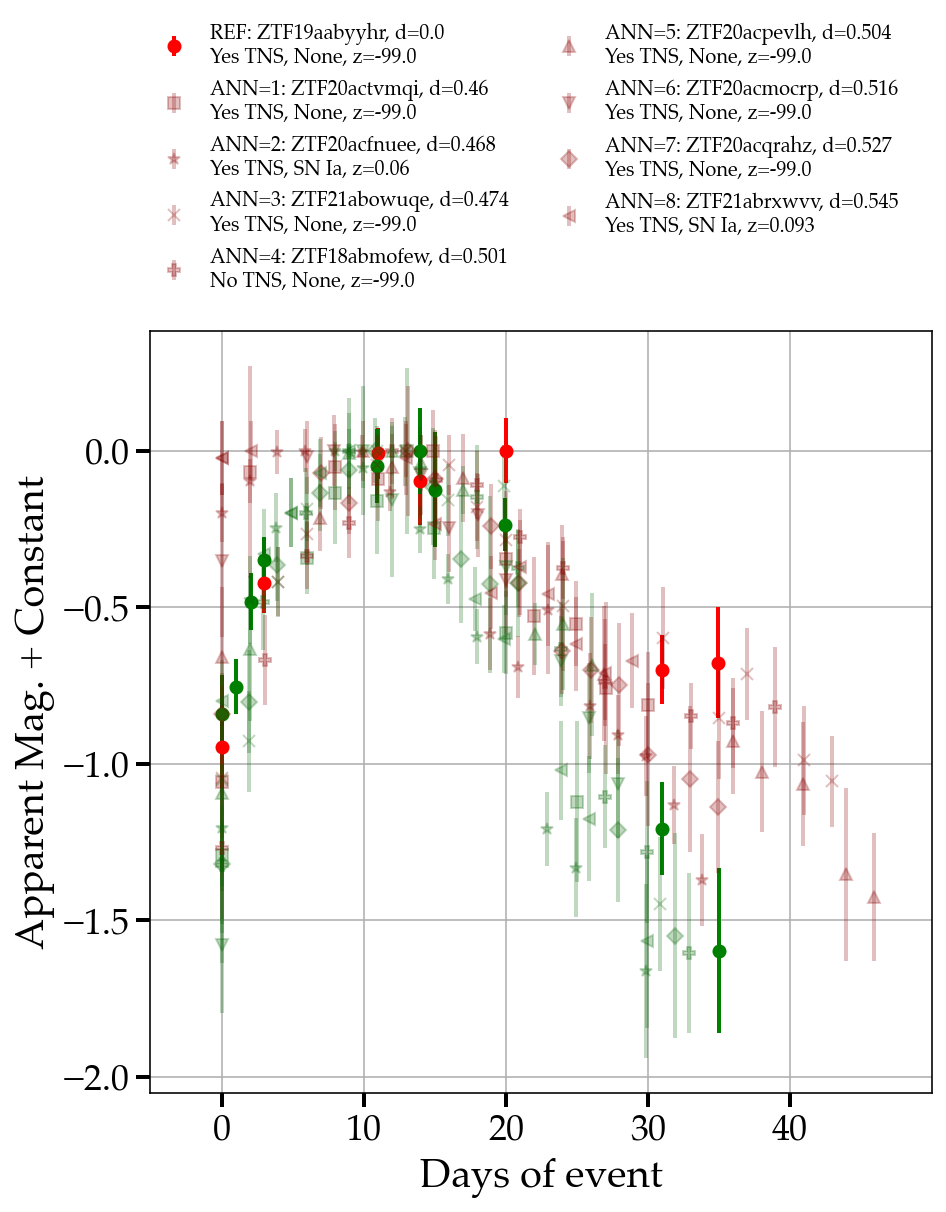

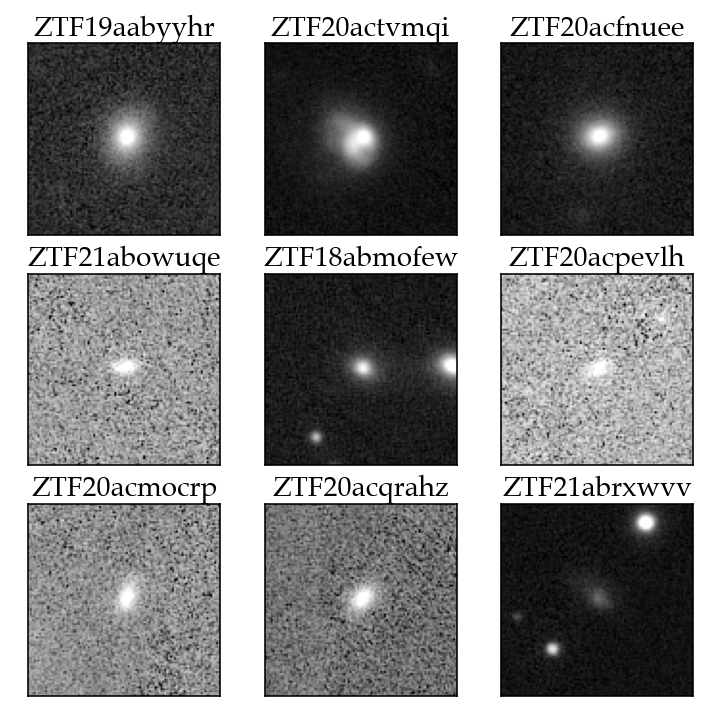

CPU times: user 4.25 s, sys: 165 ms, total: 4.41 s
Wall time: 11.9 s


In [82]:
%%time

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

ztf_id_ref = idx_arr[result_id[0]]
ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

ra_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].raMean
dec_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].decMean
host_df_ztf_id_l.append(ztf_id_ref), host_df_ra_l.append(ra_ref), host_df_dec_l.append(dec_ref)


fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[0], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
            label=f'REF: {ztf_id_ref}, d={round(result_dist[0], 3)}\n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[0], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
#ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1]-df_ref_r.ant_mag.min(), s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = result_id[1:9]
ztf_dist_l = result_dist[1:9]

for num, loc in enumerate(ztf_id_l):
    ztf_id_ann = idx_arr[ztf_id_l[num]]

    l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
    try:
        df_knn = l_info.timeseries.to_pandas()
    except: continue    
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z
    
    ra_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].decMean
    host_df_ztf_id_l.append(ztf_id_ann), host_df_ra_l.append(ra_i), host_df_dec_l.append(dec_i)

    df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]

    ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[0], y=df_r.ant_mag.min()-df_r.ant_mag, yerr=df_r.ant_magerr, 
                fmt=markers[num], c='darkred', alpha=0.25, 
                label=f'ANN={num+1}: {ztf_id_ann}, d={round(ztf_dist_l[num], 3)}\n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}')
    ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[0], y=df_g.ant_mag.min()-df_g.ant_mag, yerr=df_g.ant_magerr, 
                fmt=markers[num], c='darkgreen', alpha=0.25)
    #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]-df_r.ant_mag.min(), s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

    plt.ylabel('Apparent Mag. + Constant')
    plt.xlabel('Days of event')
    plt.xlim(-5, df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    plt.legend(frameon=False,
               bbox_to_anchor=(0.98,1.43),
               ncol=2,
               prop={'size': 10})

    plt.grid(True)
    
plt.savefig(f'../figures/{ztf_id_ref}_ann={num+1}.jpg', dpi=150, bbox_inches='tight')

host_5ann_df = pd.DataFrame(zip(host_df_ztf_id_l, host_df_ra_l, host_df_dec_l), columns=['name', 'ra', 'dec'])

host_pdfs(df=host_5ann_df)

In [96]:
# Common Values
# Value	Count	Frequency (%)
# None	14328	93.7%
# SN Ia	651	 4.3%
# SN II	141	 0.9%
# SN IIn	26	 0.2%
# SN Ia-91T-like	24	 0.2%
# SN Ib	15	 0.1%
# SN Ic	15	 0.1%
# SN IIb	11	 0.1%
# TDE	9	 0.1%
# SN IIP	9	 0.1%
# Other values (18)	65	 0.4%

# TODO: Make plot of Merged Thumbnails of host galaxies!

In [46]:
dataset_bank

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.560191,0.424848,0.208939,-0.480166,0.117709,0.045476,0.656291,-0.087113,0.003637,-0.301314,...,-0.179979,0.027798,0.050688,-0.033743,0.169485,-0.074625,-0.041968,-0.096716,0.104612,-0.001487
ZTF18acfvwwa,0.664265,0.530860,-0.016822,0.141054,-0.207321,-0.155185,0.408786,-0.123985,-0.091939,-0.243788,...,0.279985,0.065703,0.071586,-0.067874,0.146434,-0.018109,0.010411,0.079630,0.225589,-0.001728
ZTF20aciscxz,-0.291376,-0.722325,-0.097066,-0.205800,-0.198077,-0.267763,-0.116517,-0.296293,-0.044390,0.336877,...,0.092787,0.004462,0.052942,0.009744,0.220747,-0.225790,-0.030226,0.171339,-0.079655,-0.034829
ZTF18abdkosj,0.036447,1.273626,-0.230453,-0.084489,0.815455,0.160496,-0.444929,0.634291,-0.070836,0.301971,...,0.134738,-0.340836,0.067010,0.034299,0.165625,-0.090927,-0.065426,0.082431,0.099951,-0.112872
ZTF18abrcoty,-0.482680,-0.713043,-0.354130,0.021685,0.668199,0.463274,-0.151313,-0.294015,0.541775,0.004779,...,-0.197691,-0.236953,-0.218749,0.071574,0.118753,-0.278500,-0.003007,0.092487,0.330561,0.093801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaqzrov,0.046297,-0.396499,-0.323047,0.426791,0.698077,-0.516220,0.455106,0.394558,-0.352160,-0.183396,...,0.088062,-0.048375,0.095508,-0.125882,-0.289251,-0.139091,0.058277,0.138899,-0.089081,0.067250
ZTF18abryurz,-1.094431,1.356183,0.220728,-0.625607,-0.349833,-0.191417,0.035189,0.488623,-0.265971,-0.293116,...,-0.278834,0.116294,0.148673,-0.184850,0.063329,0.137263,0.049843,0.408931,-0.133803,-0.044804
ZTF18aaokokk,0.518545,0.281588,0.267237,-0.394557,-0.296436,-0.007809,-0.096790,-0.437330,-0.081810,0.070239,...,-0.190444,0.139264,-0.101133,0.031935,0.180884,0.060398,-0.001278,-0.150593,-0.000215,-0.182237


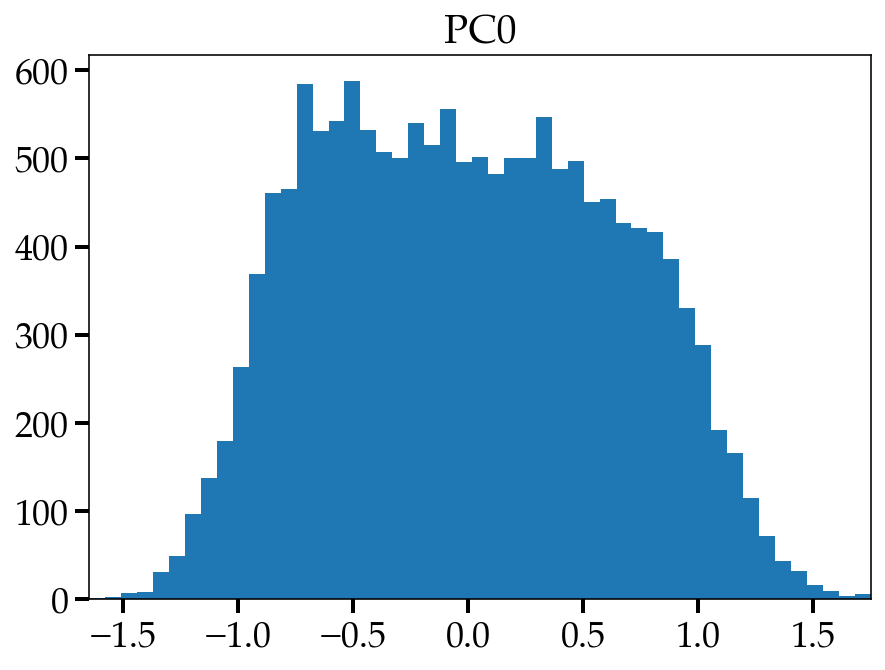

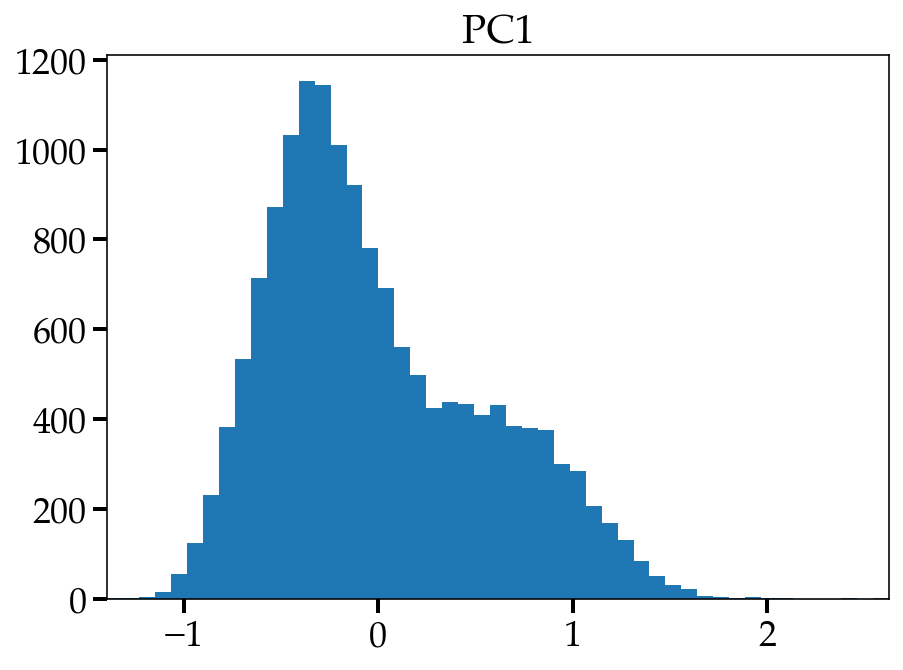

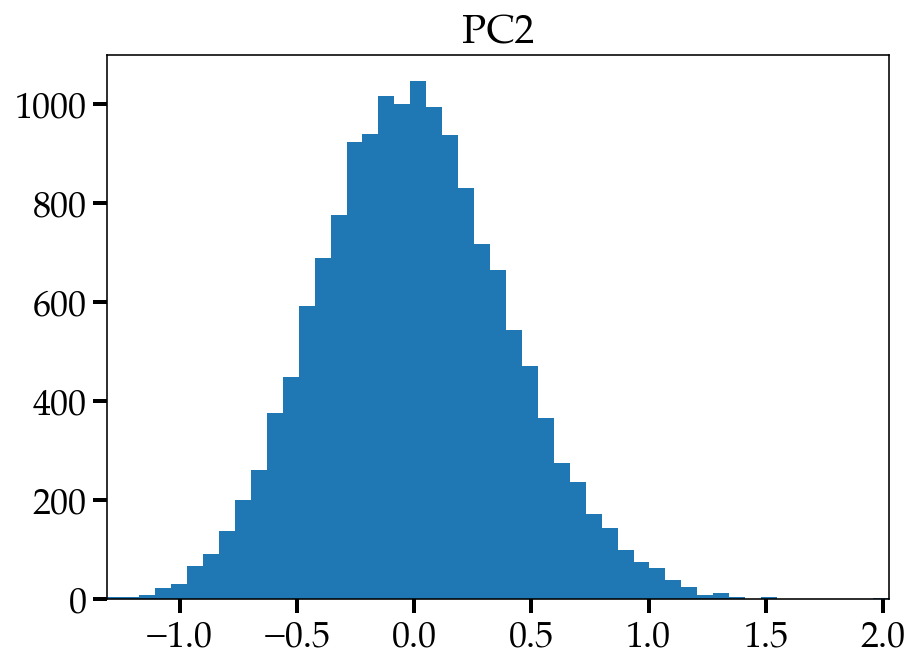

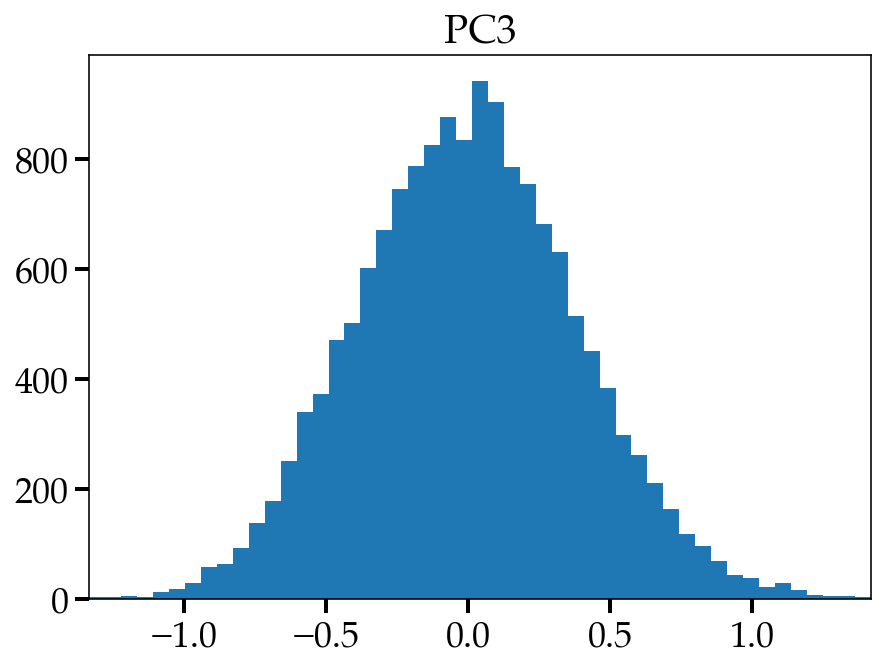

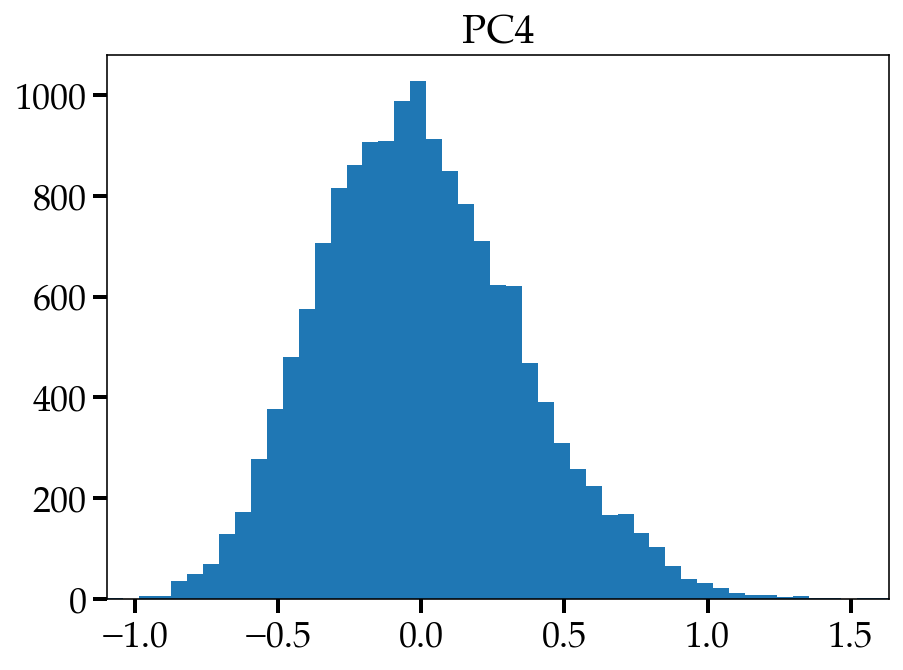

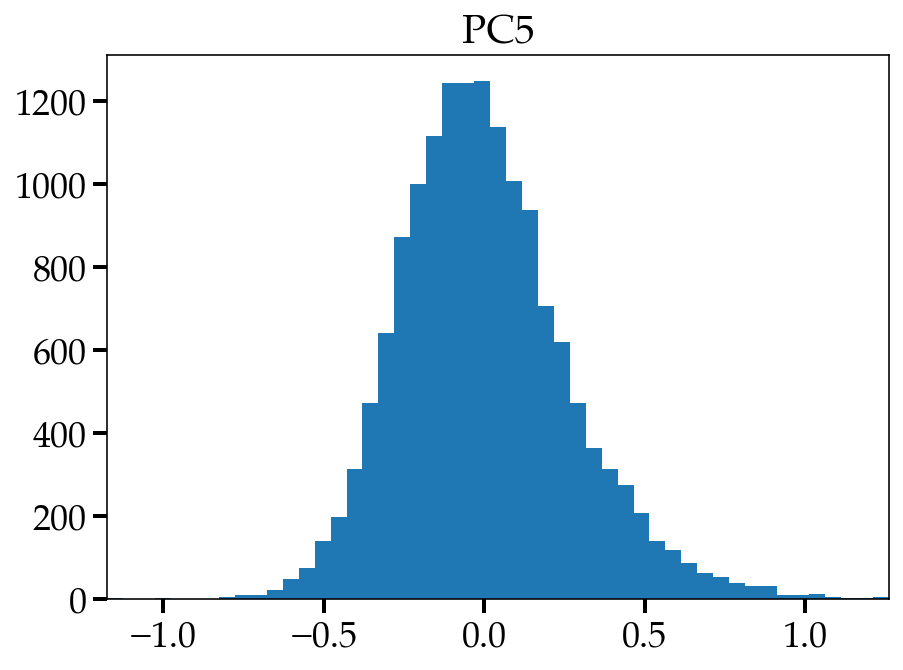

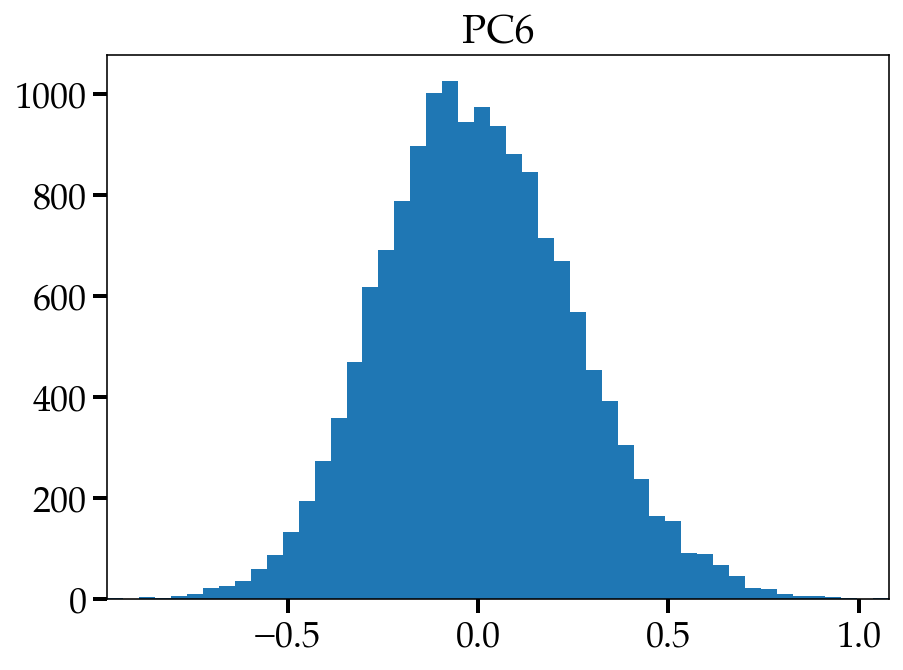

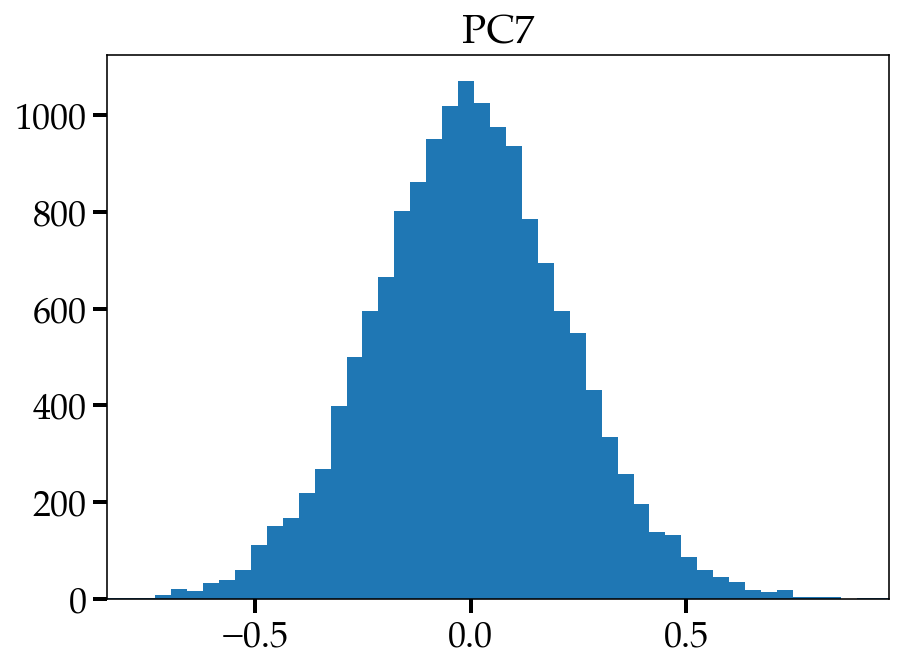

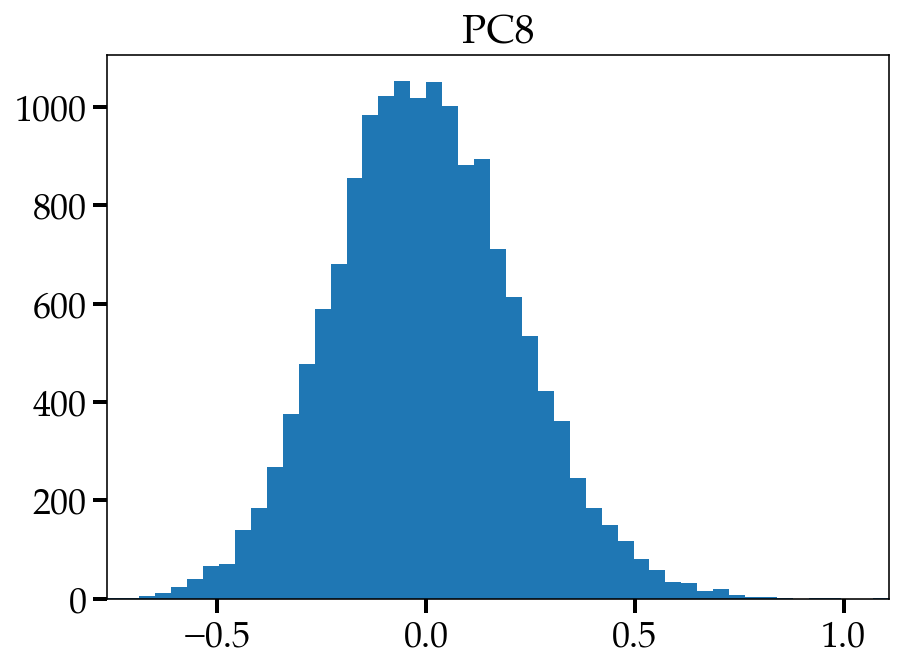

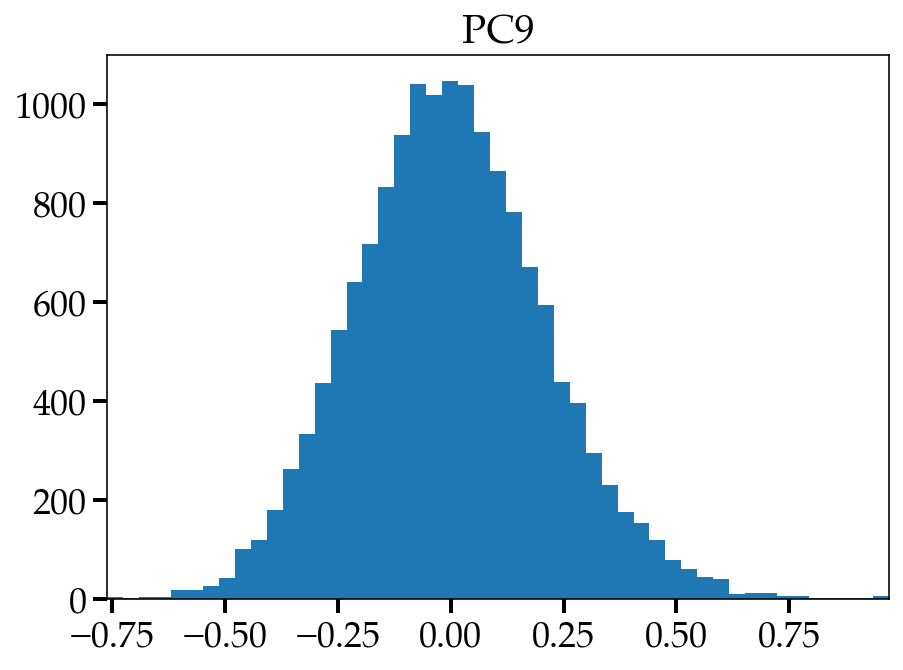

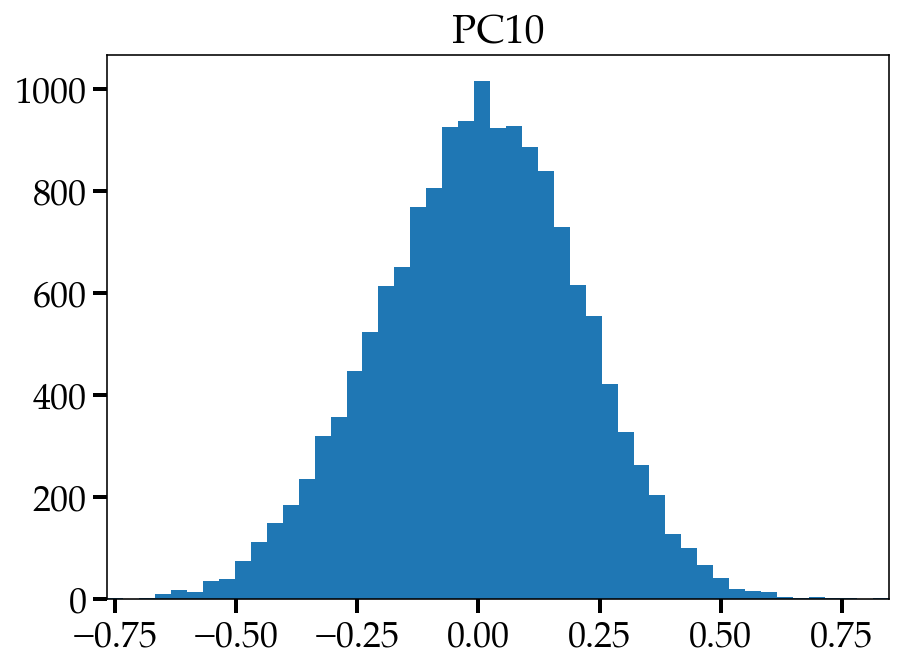

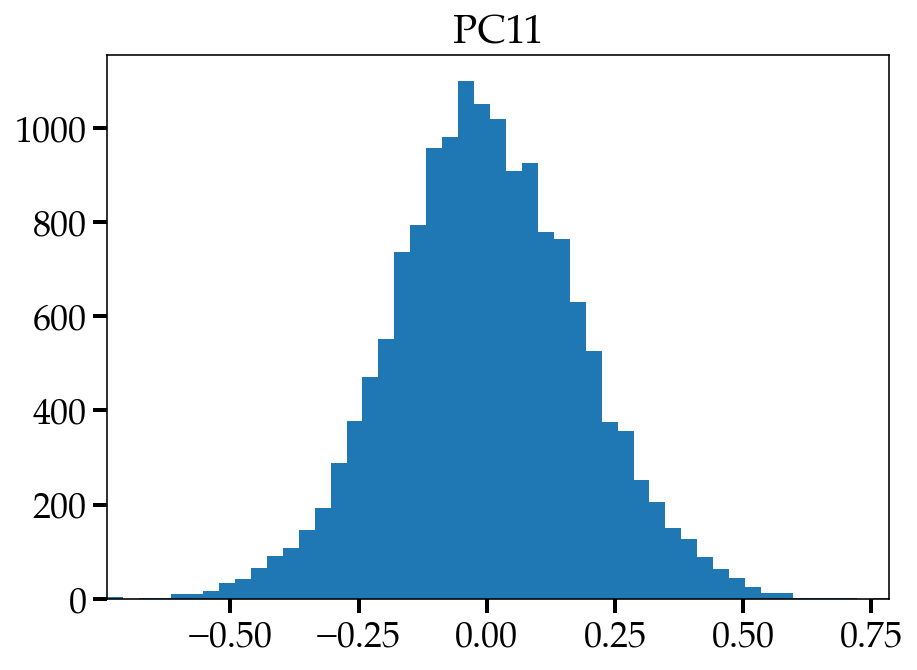

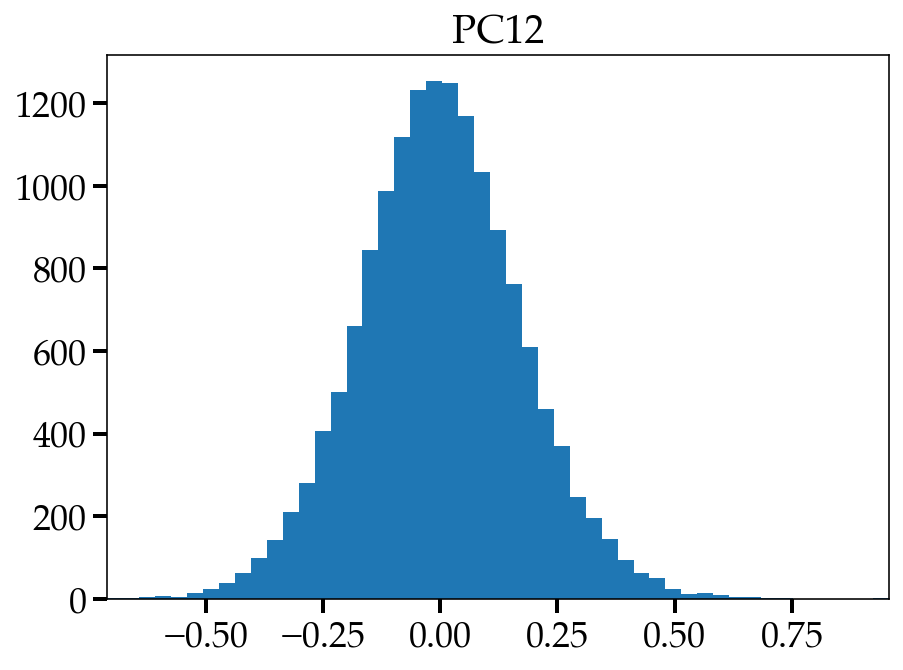

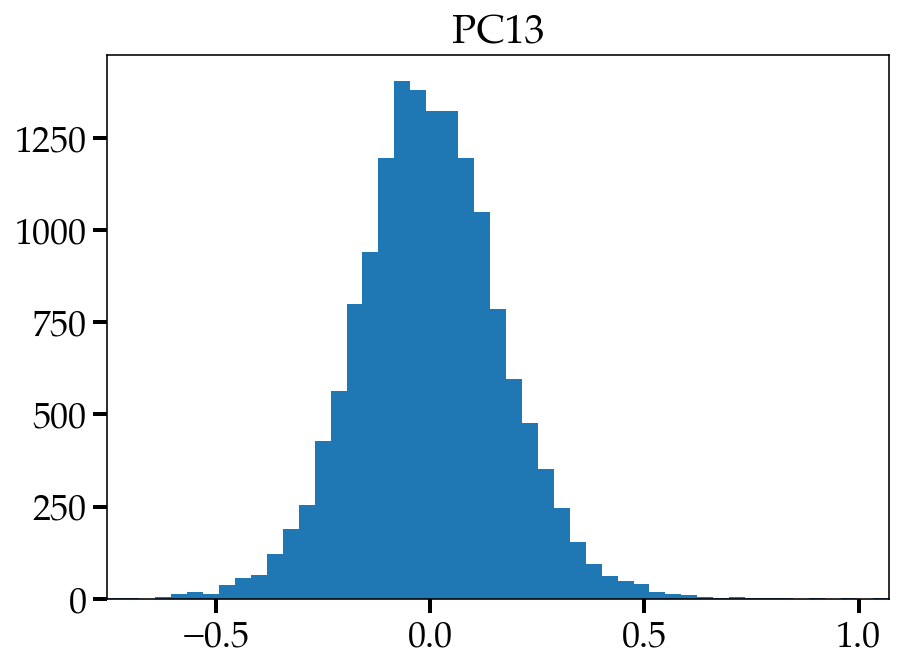

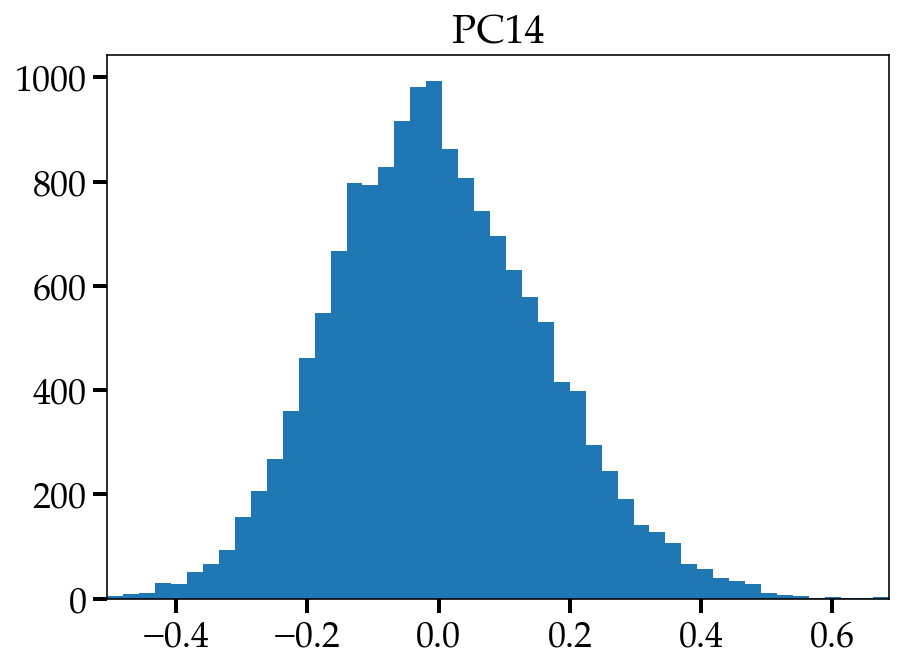

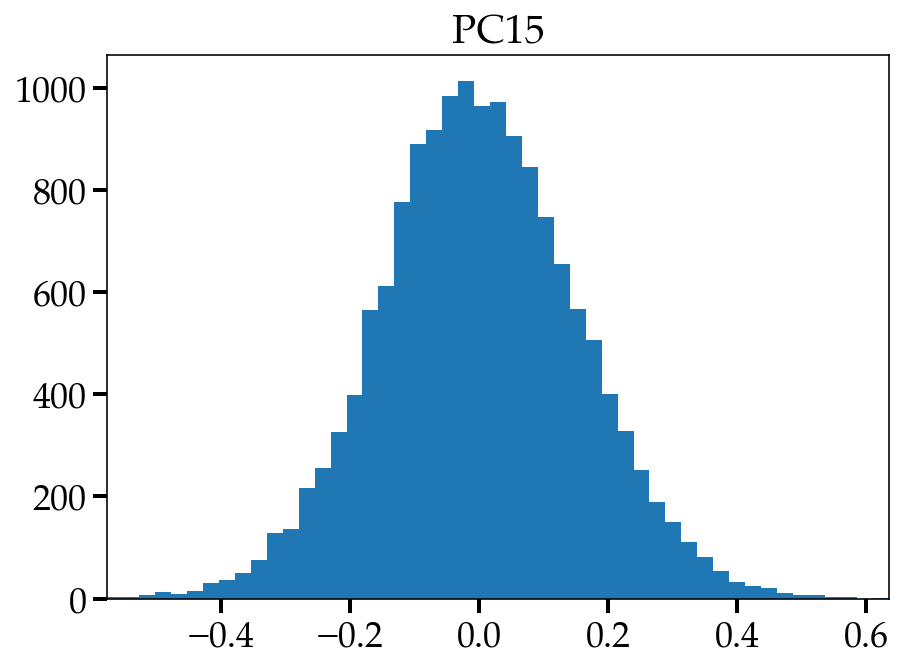

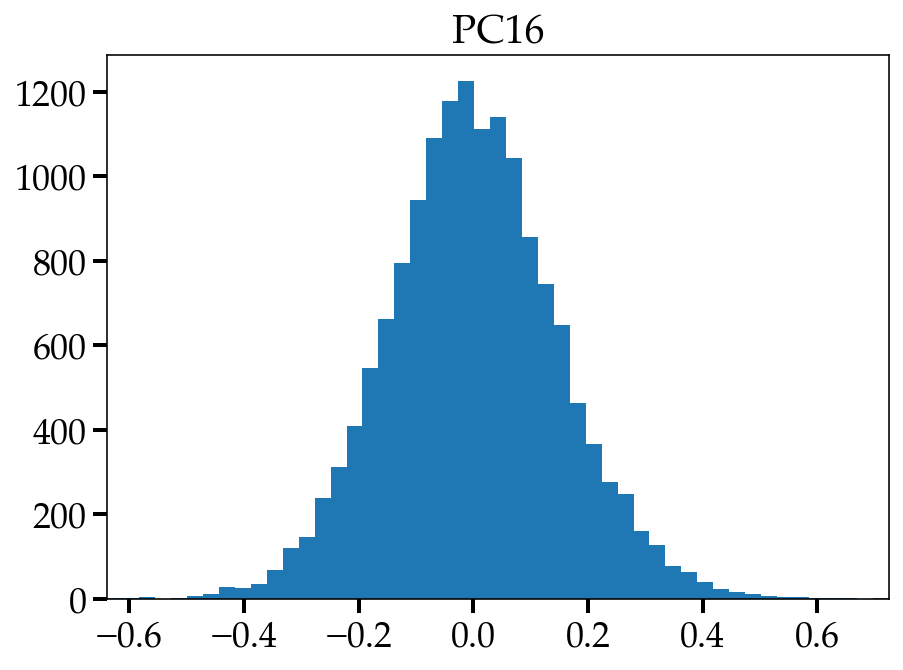

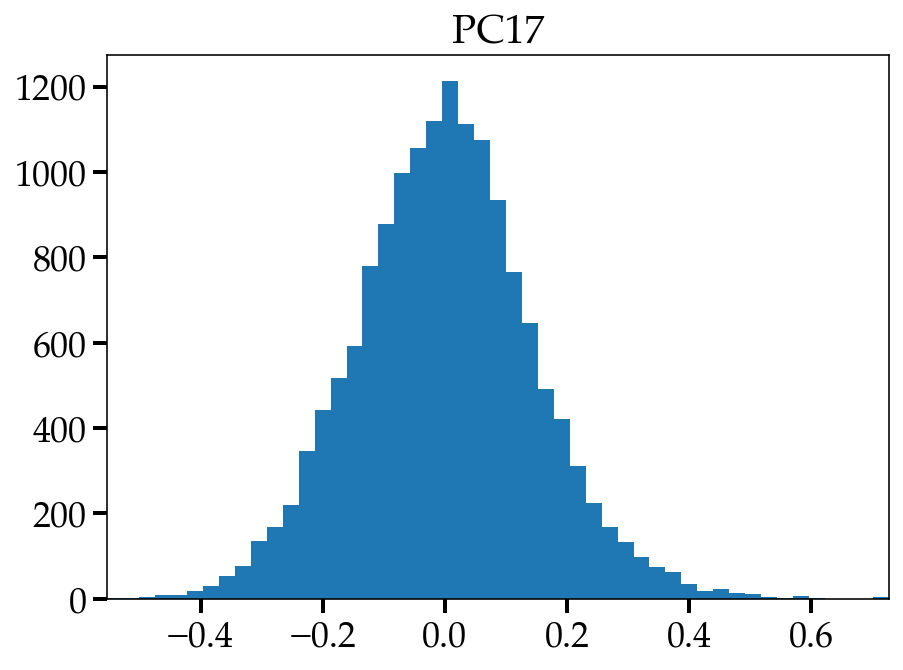

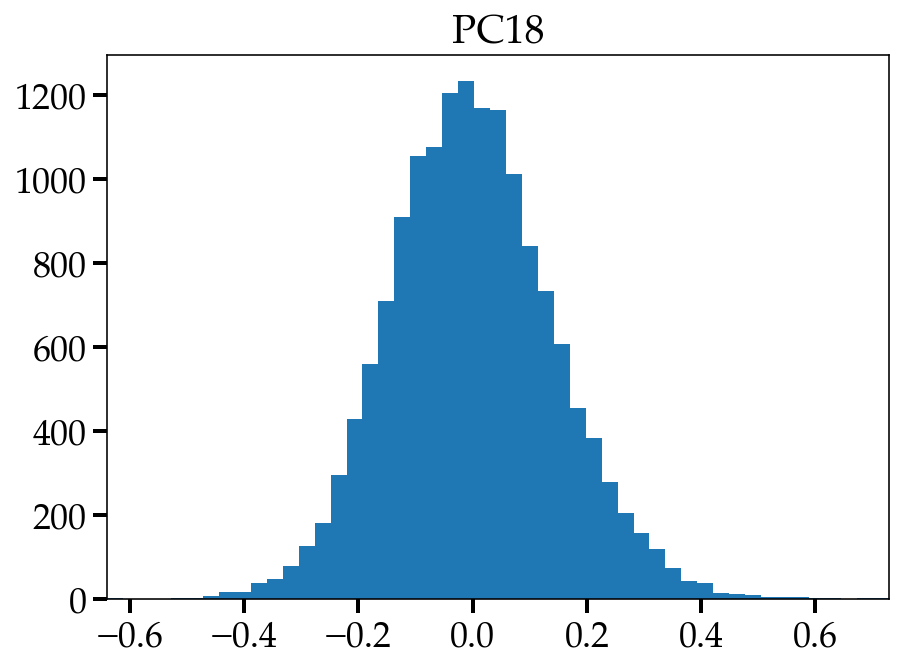

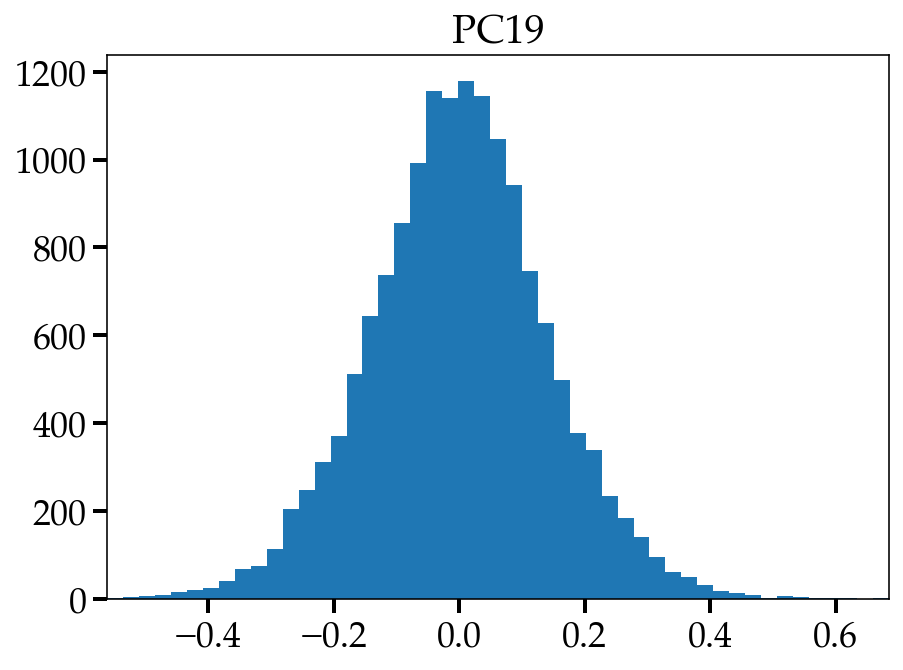

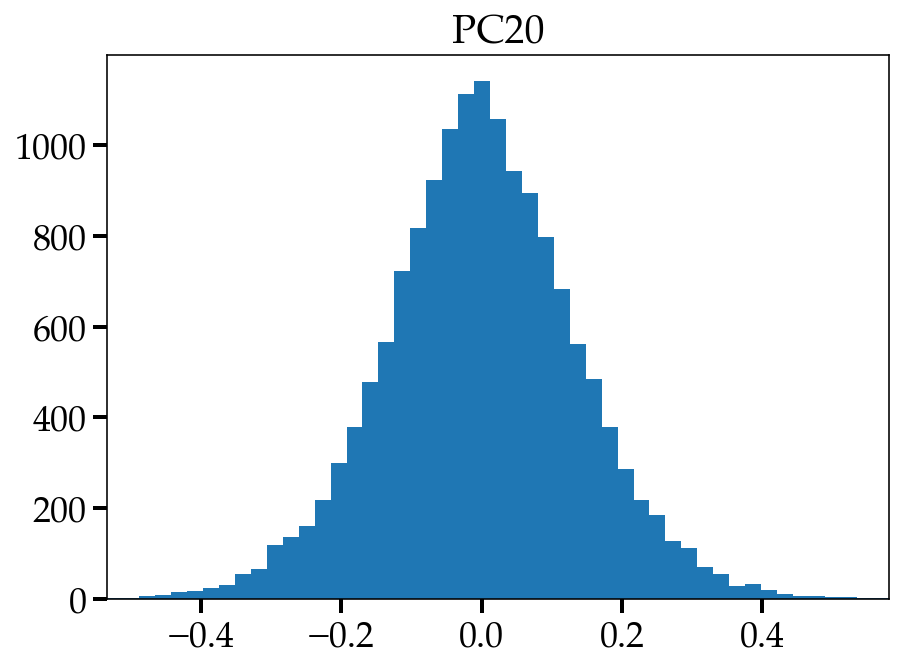

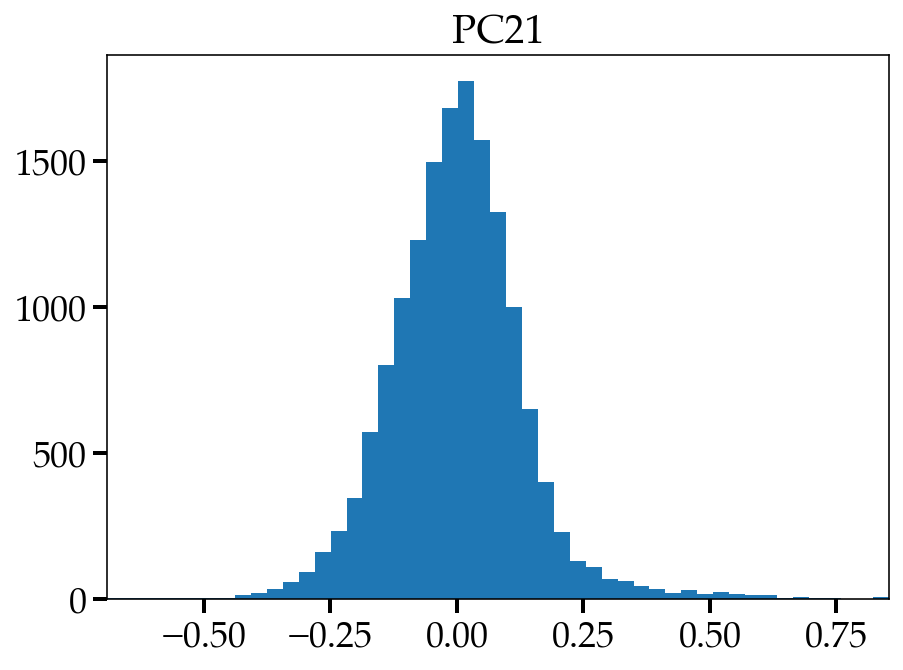

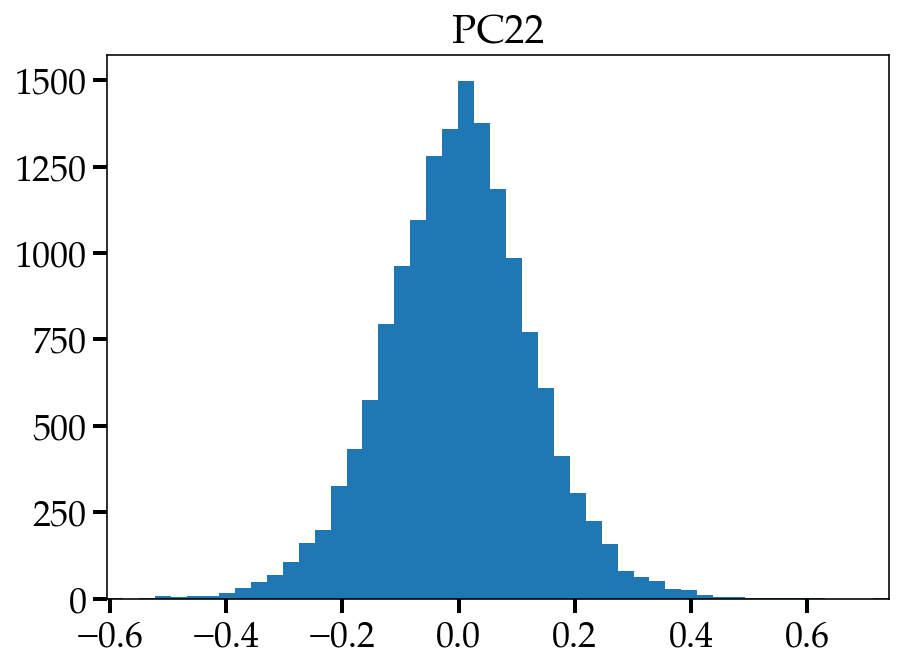

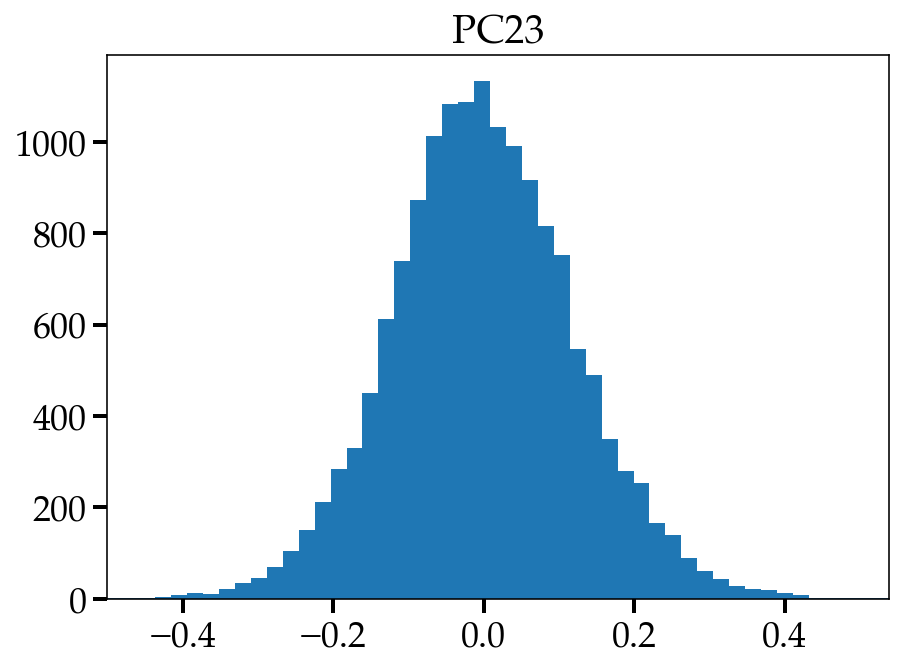

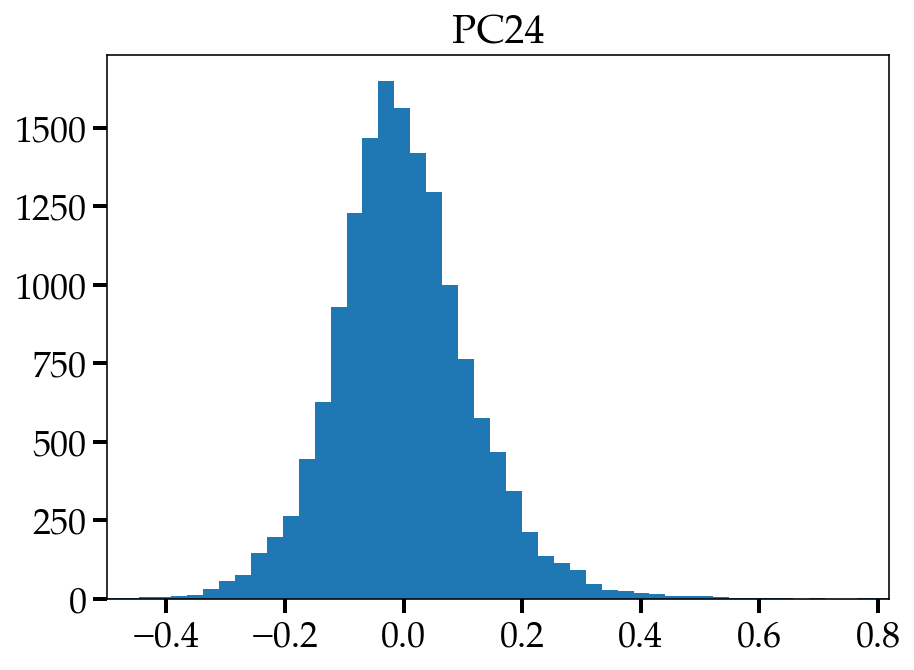

In [47]:
feat_scatter_l = []
for feat in dataset_bank.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(dataset_bank[feat], bins=np.linspace(min_feat, max_feat, 50))
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.show()
    
    feat_scatter = np.std(dataset_bank[feat])
    feat_scatter_l.append(feat_scatter)    

In [48]:
print("Scatter mean:", np.mean(feat_scatter_l))
print("Scatter median:", np.median(feat_scatter_l))
print("Scatter std:", np.std(feat_scatter_l))
print("Scatter max:", np.max(feat_scatter_l))
print("Scatter min:", np.min(feat_scatter_l))

Scatter mean: 0.23124111412815246
Scatter median: 0.17315220090849529
Scatter std: 0.1332226516044428
Scatter max: 0.6329129336372623
Scatter min: 0.11735223639862415


In [49]:
list(np.unique(dataset_bank_orig.index))

['ZTF17aaaazmz',
 'ZTF17aaabghb',
 'ZTF17aaabuab',
 'ZTF17aaaceht',
 'ZTF17aaadqdy',
 'ZTF17aaadqyf',
 'ZTF17aaadvbj',
 'ZTF17aaadvbq',
 'ZTF17aaaeqwm',
 'ZTF17aaaesne',
 'ZTF17aaaessf',
 'ZTF17aaaeszu',
 'ZTF17aaafssi',
 'ZTF17aaafstx',
 'ZTF17aaafvft',
 'ZTF17aaafvwp',
 'ZTF17aaahfef',
 'ZTF17aaahmid',
 'ZTF17aaaikkq',
 'ZTF17aaaiujz',
 'ZTF17aaajigm',
 'ZTF17aaajtpw',
 'ZTF17aaakiey',
 'ZTF17aaanjkj',
 'ZTF17aaaosws',
 'ZTF17aaarsja',
 'ZTF17aaastat',
 'ZTF17aaaszpi',
 'ZTF17aaategd',
 'ZTF17aaatkcm',
 'ZTF17aaatuke',
 'ZTF17aaatukm',
 'ZTF17aaatuld',
 'ZTF17aaatuyr',
 'ZTF17aaatvkt',
 'ZTF17aaatxik',
 'ZTF17aaatxjg',
 'ZTF17aaatyyh',
 'ZTF17aaawdfs',
 'ZTF17aaaweop',
 'ZTF17aaawfja',
 'ZTF17aaaxbgi',
 'ZTF17aaaxbpe',
 'ZTF17aaaxcuq',
 'ZTF17aaaxddg',
 'ZTF17aaaxdrt',
 'ZTF17aaaxehr',
 'ZTF17aaaxepf',
 'ZTF17aaaxepp',
 'ZTF17aaaxfzx',
 'ZTF17aaaxklm',
 'ZTF17aaaxpie',
 'ZTF17aaayhze',
 'ZTF17aaayial',
 'ZTF17aaaylgr',
 'ZTF17aaaylji',
 'ZTF17aaayqxe',
 'ZTF17aaazdba',
 'ZTF17aaazmzw

In [50]:
%%time

ref_name_l, id_l, dist_l = [], [], []
for ref in list(np.unique(dataset_bank.index)):
    dataset_ref = dataset_bank[dataset_bank.index == ref] 

    feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
    scaled_feat_arr_ref = feat_arr_ref # PCA, so already scaled

    snid = dataset_ref.index.values[0]
    lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
    #lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

    #result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
    result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
    
    ref_name_l.append(snid), id_l.append(result_id), dist_l.append(result_dist)
    
temp_df = pd.DataFrame(zip(ref_name_l, id_l, dist_l), columns=['Reference', 'ids', 'dists'])
temp_df = temp_df.set_index('Reference')
ann_split_df = temp_df.merge(pd.DataFrame(temp_df['ids'].values.tolist()).add_prefix('ann='), on=temp_df.index)
ann_split_df = ann_split_df.set_index('key_0')
ann_dist_all_df = ann_split_df.merge(pd.DataFrame(ann_split_df['dists'].values.tolist()).add_prefix('dist='), on=ann_split_df.index)
ann_dist_all_df = ann_dist_all_df.drop(columns=['ids', 'dists'])
ann_dist_all_df = ann_dist_all_df.set_index('key_0')

# find average (mean) distance of first 9 ANNs.
col_list= [f'dist={col}' for col in range(1, 10)]
# sum specific columns
ann_dist_all_df[f'Mean-{len(col_list)}ANNs'] = (ann_dist_all_df[col_list].sum(axis=1))/(len(col_list))

# weighted distance of first 9 ANNs
weight_l = [34, 21, 13, 8, 5, 3, 2, 1, 1] # Fibonacci seq.
ann_dist_all_df[f'WeightedMean-{len(col_list)}ANNs'] = np.average(ann_dist_all_df[col_list], weights=weight_l, axis=1)
ann_dist_all_df

CPU times: user 26.7 s, sys: 350 ms, total: 27.1 s
Wall time: 27.6 s


,ann=0,ann=1,ann=2,ann=3,ann=4,ann=5,ann=6,ann=7,ann=8,ann=9,...,dist=2,dist=3,dist=4,dist=5,dist=6,dist=7,dist=8,dist=9,Mean-9ANNs,WeightedMean-9ANNs
key_0,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaazmz,9270,4192,10845,3554,14155,5249,13778,10107,13738,14386,...,0.684023,0.738692,0.755304,0.773870,0.785409,0.813500,0.814088,0.817577,0.759638,0.701585
ZTF17aaabghb,7722,8338,10671,2010,11726,2260,13693,7514,11832,11733,...,0.561278,0.581126,0.585923,0.651349,0.656001,0.682243,0.682508,0.685925,0.624030,0.568223
ZTF17aaabuab,13751,12692,2743,1948,2453,3868,5936,13717,6465,6671,...,0.740856,0.780917,0.785076,0.791114,0.799161,0.809077,0.810816,0.820227,0.783227,0.747659
ZTF17aaaceht,2529,7553,14916,7966,9586,256,8439,10965,14471,7424,...,0.736698,0.768126,0.836774,0.858914,0.859365,0.878311,0.881507,0.884550,0.817628,0.736315
ZTF17aaadqdy,5152,14450,11858,2734,6146,1491,11167,7790,10912,8767,...,0.819508,0.823250,0.845888,0.852250,0.852322,0.852990,0.867228,0.869649,0.831824,0.782426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acogvaq,8538,4402,3094,2775,10805,5758,13647,11400,4803,10862,...,0.644418,0.706155,0.729304,0.735125,0.764296,0.774567,0.790522,0.790801,0.723646,0.650970
ZTF21acowflo,7520,7917,9282,4441,9514,10712,10335,9497,8213,11077,...,0.718851,0.757951,0.759687,0.771375,0.775421,0.777278,0.797512,0.806086,0.756945,0.709223
ZTF21acqdfea,7770,1487,8129,9355,2912,8356,5049,1729,1147,4428,...,0.585191,0.597237,0.618849,0.625929,0.628519,0.639254,0.650825,0.667979,0.620416,0.590853


In [51]:
# Pick distance metric. 
# Weighted mean of first 9 ANNs (Fibonacci), OR Mean of first 9 ANNs, OR distance to first ANN. 
# TODO: EXPLORE DIFFERENT METRICS!
dist_col = f'WeightedMean-{len(col_list)}ANNs'  # f'Mean_{len(col_list)}ANNs' # 'dist=1'

print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df[dist_col]))
print("Scatter median:", np.median(ann_dist_all_df[dist_col]))
print("Scatter std:", np.std(ann_dist_all_df[dist_col]))
print("Scatter max:", np.max(ann_dist_all_df[dist_col]))
print("Scatter min:", np.min(ann_dist_all_df[dist_col]))
print("\n")

#Returns index of mean distance of 9 ANNs
print("Most anomalous:", ann_dist_all_df[[dist_col]].idxmax().values[0])

summary stats
Scatter mean: 0.6794310562905428
Scatter median: 0.6730227893726393
Scatter std: 0.13064085326272049
Scatter max: 1.6540414569052784
Scatter min: 0.35504047640345315


Most anomalous: ZTF19aaeyltm


# Largest distance


### either bogus (bright "obs" at core which aren't real)
### intense variable star
### bright/ nearby SN
### big gaps
### quick rise and then no obs until much later
### some truly weird ones (20acct)

In [52]:
ref_obj = ann_dist_all_df[[dist_col]].idxmax().values[0] #'ZTF18acbwaxk'
print("Max dist", ann_dist_all_df.loc[ref_obj][dist_col]) 

Max dist 1.6540414569052784


In [53]:
dataset_bank[dataset_bank.index == ref_obj]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19aaeyltm,-0.426498,1.38195,0.760667,-0.487394,0.986068,0.418834,-0.52241,-0.081918,-0.020659,0.332597,...,0.063683,0.11365,0.70576,0.056202,0.408902,-0.023745,0.683467,0.35367,-0.167445,-0.114556


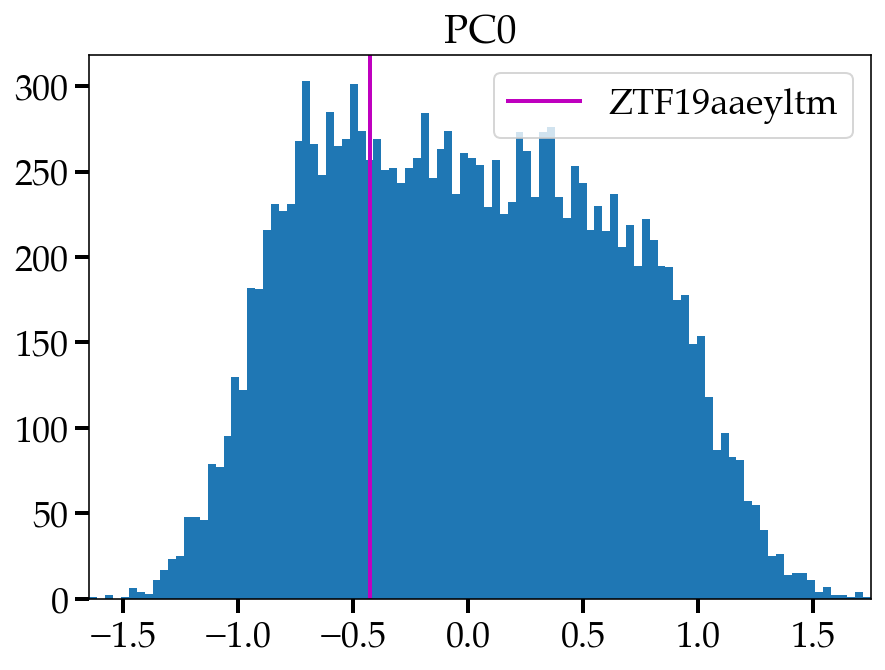

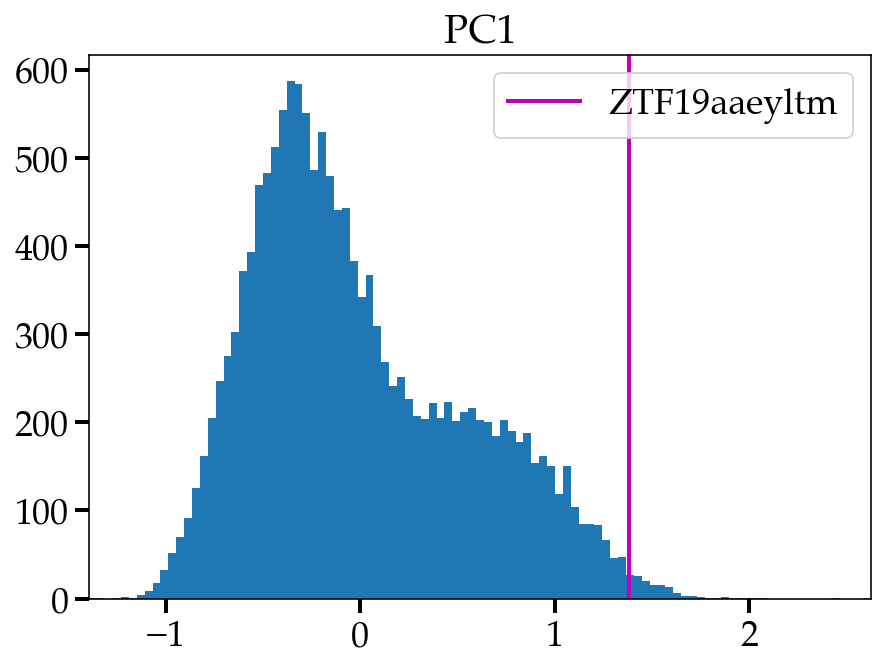

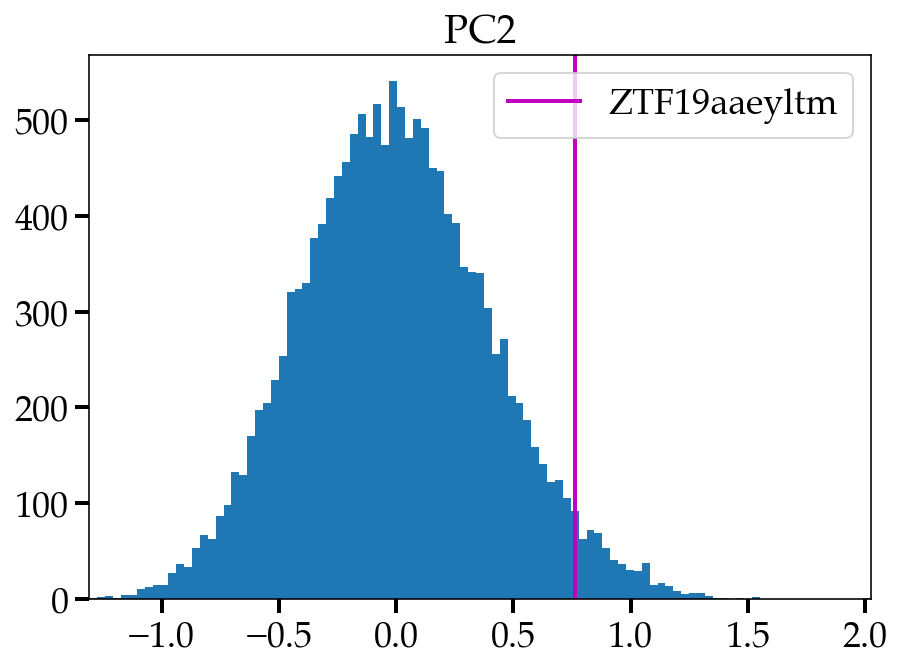

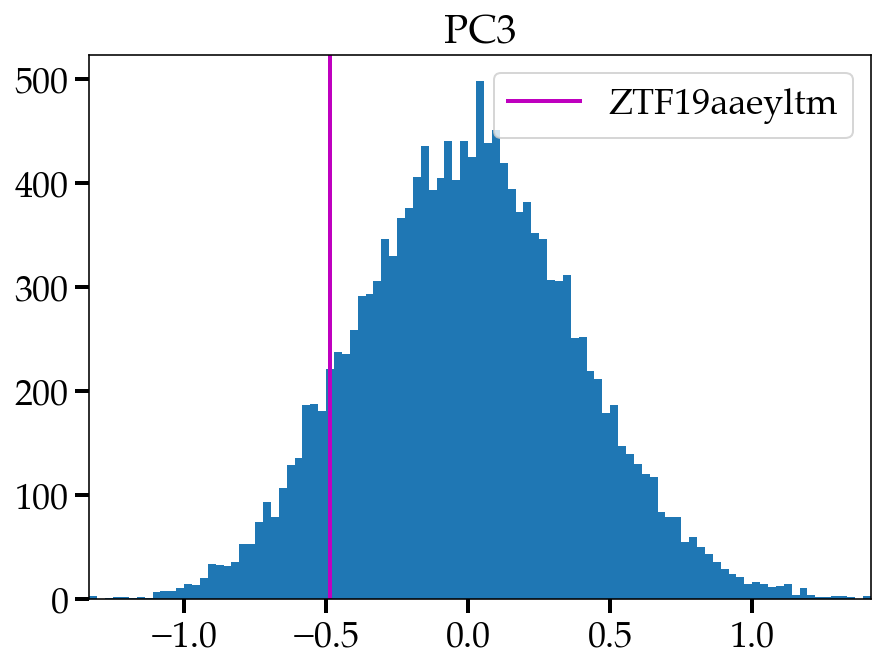

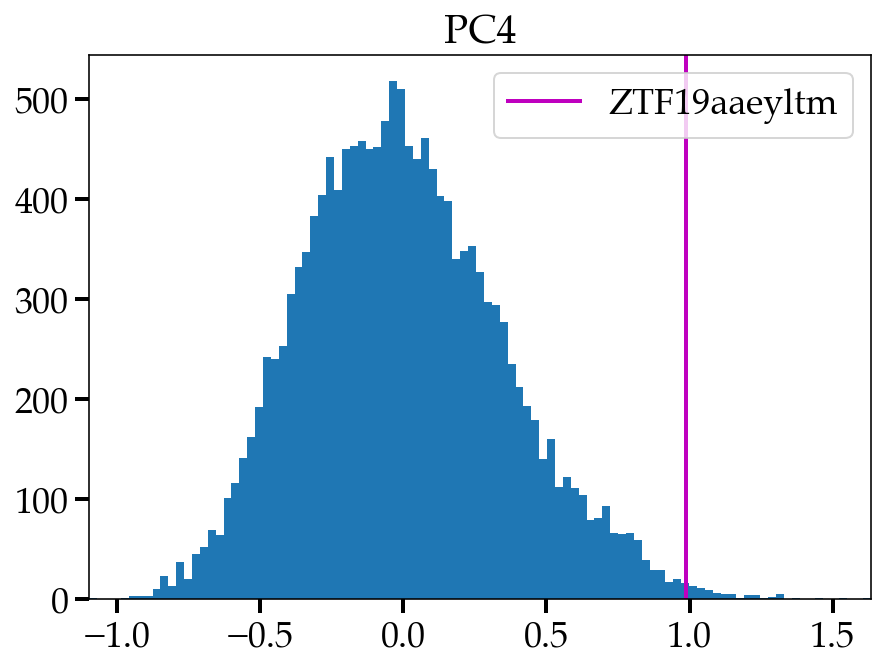

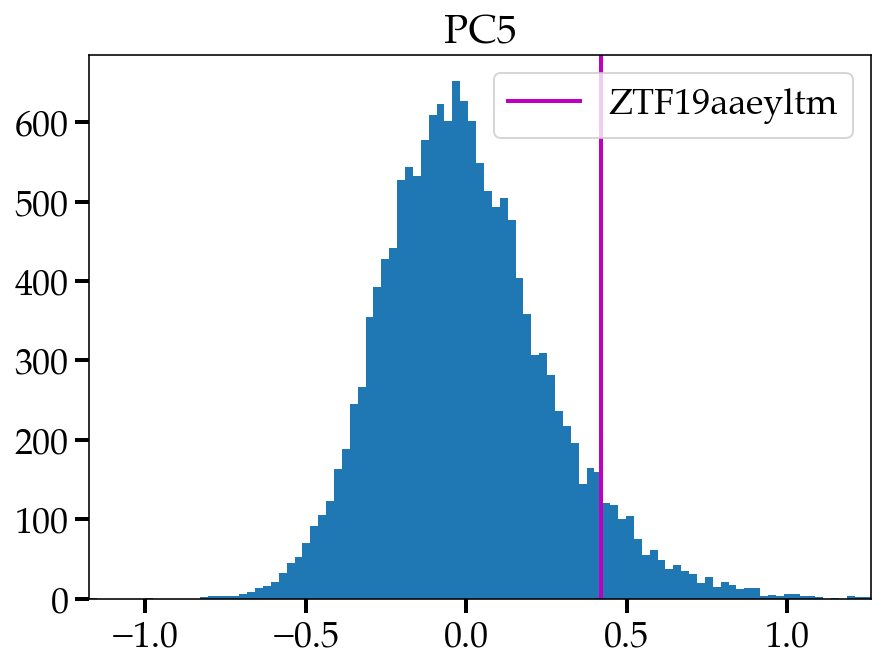

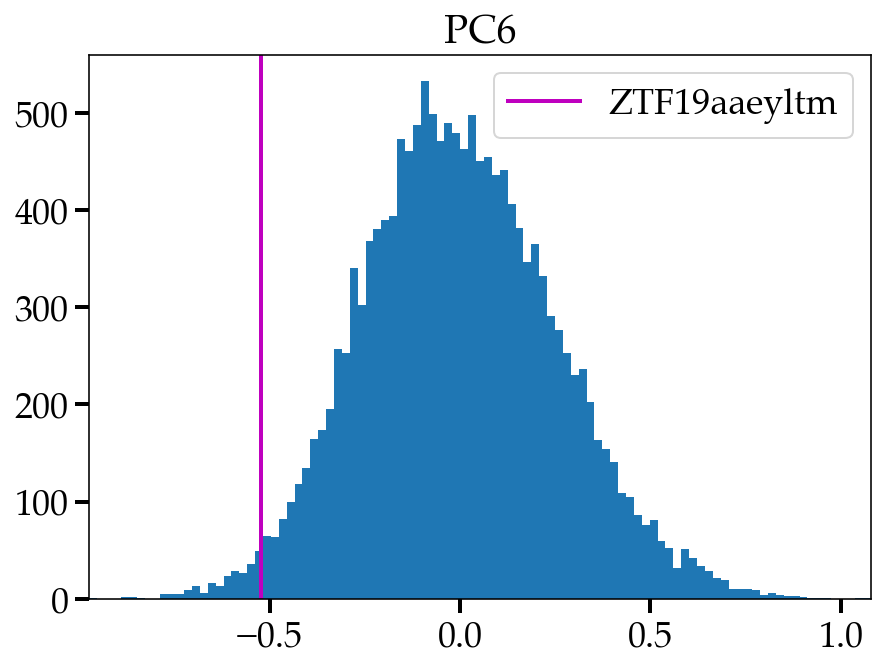

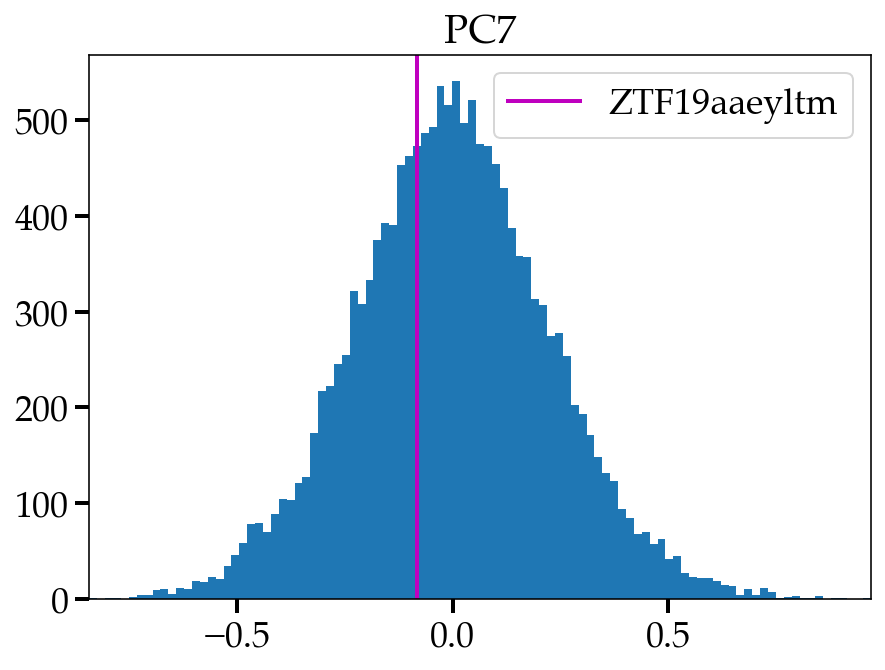

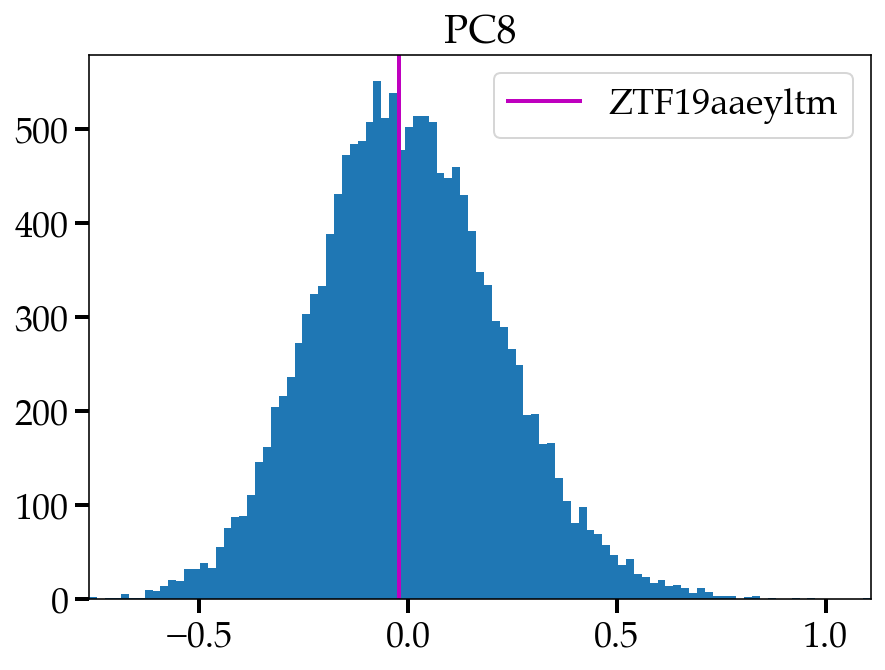

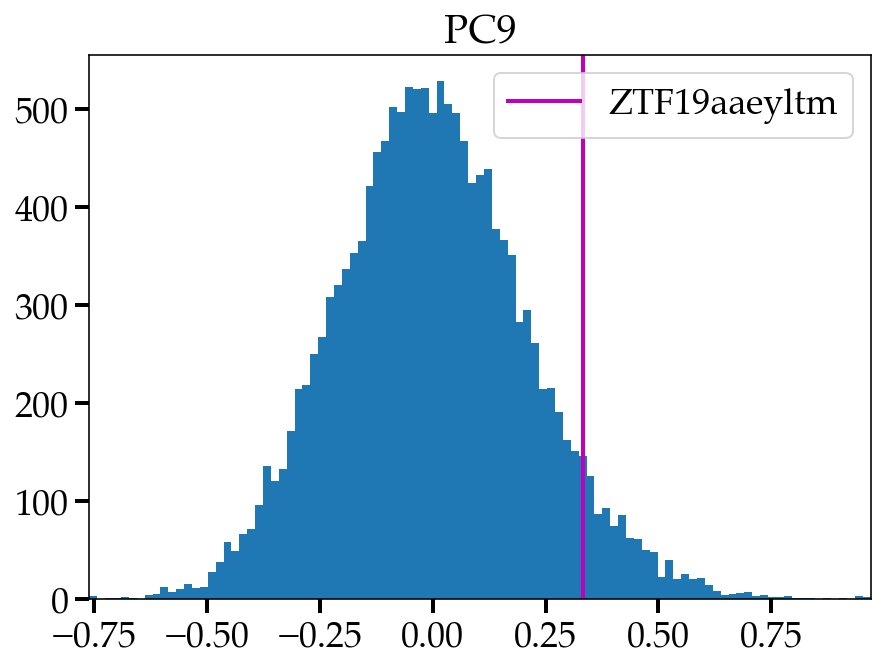

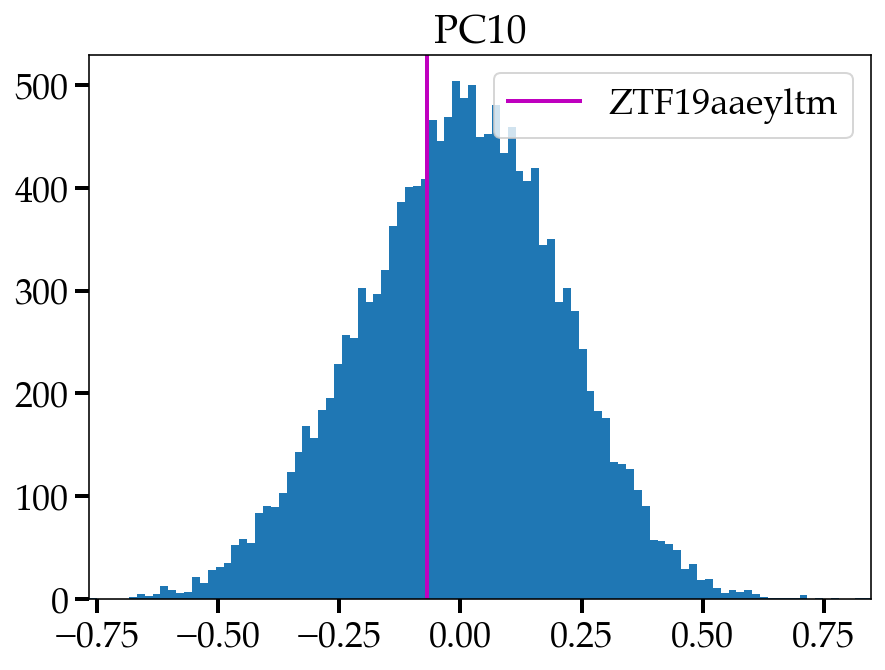

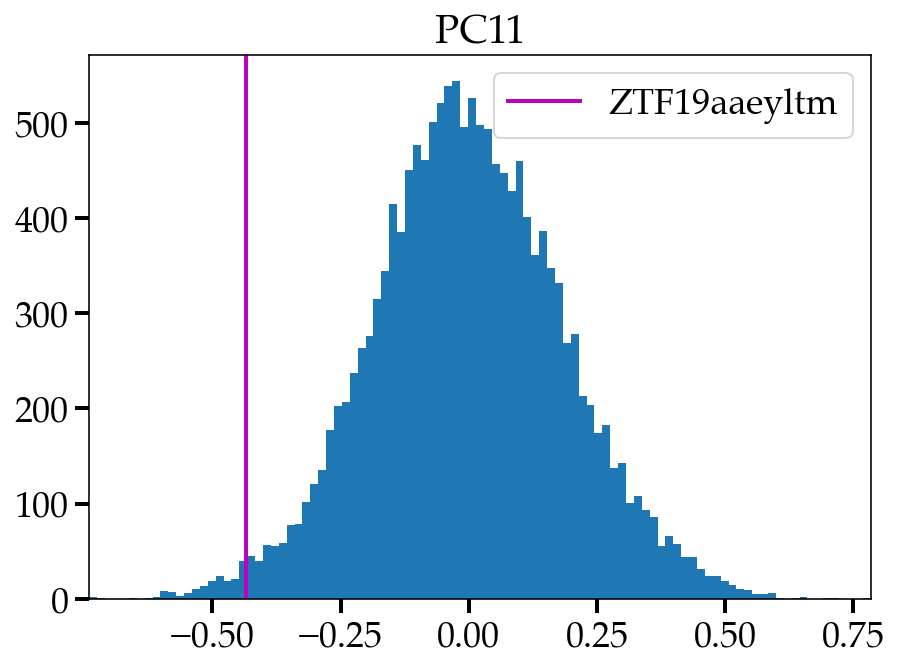

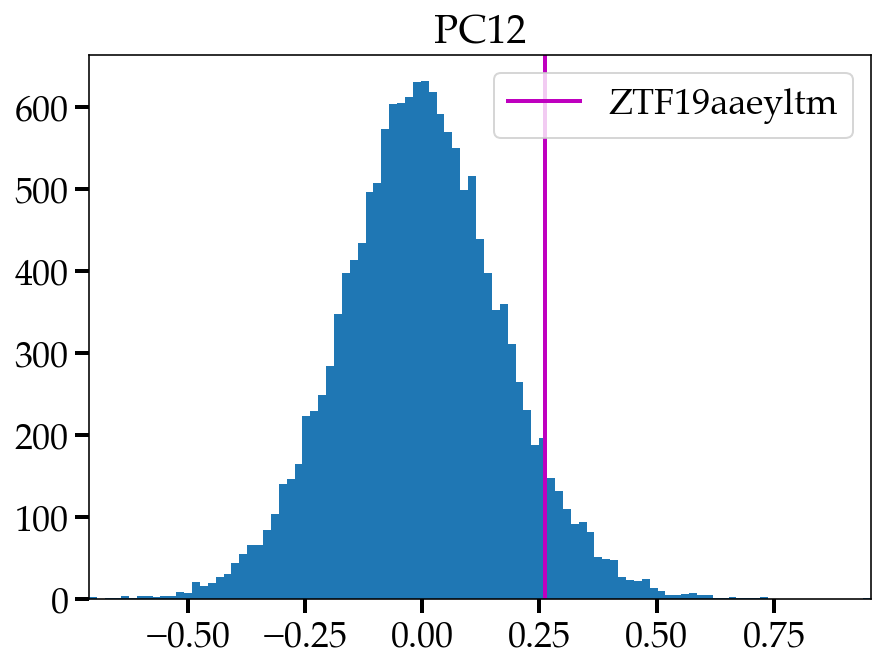

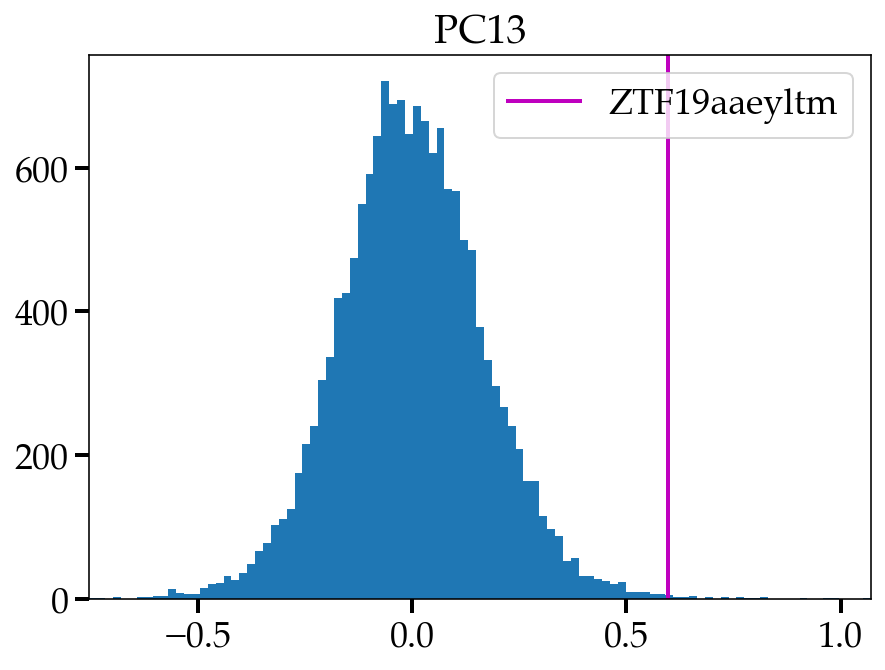

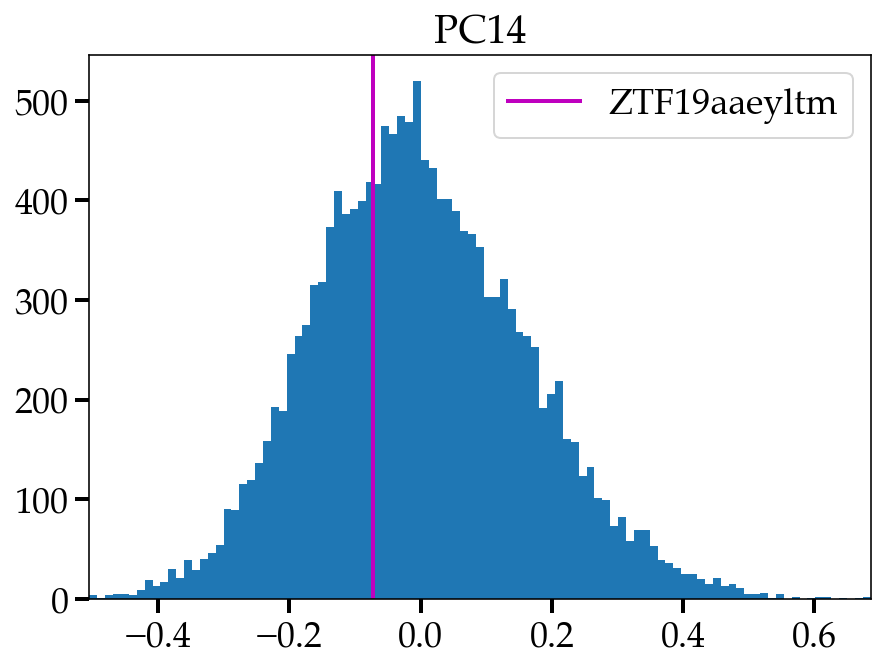

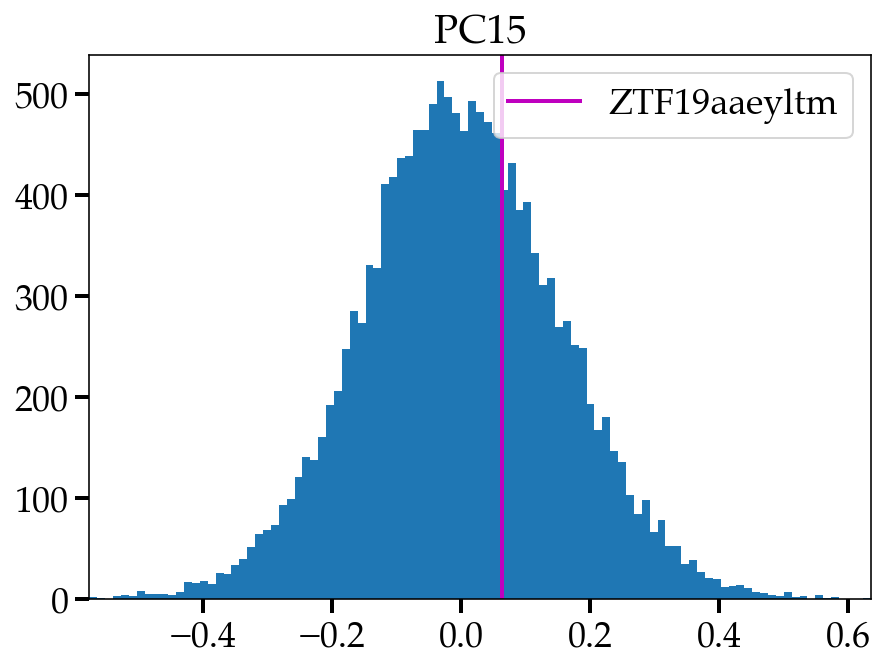

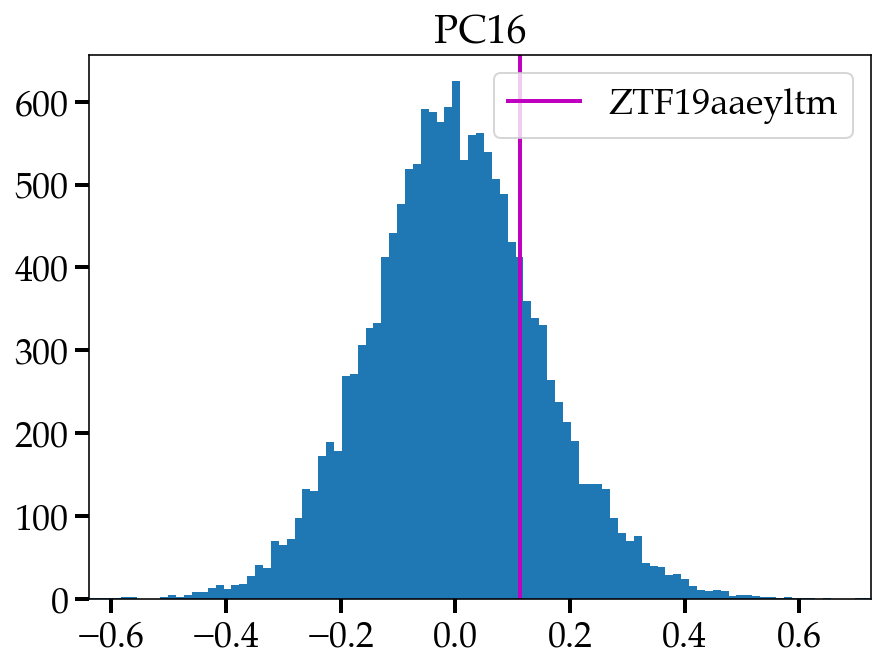

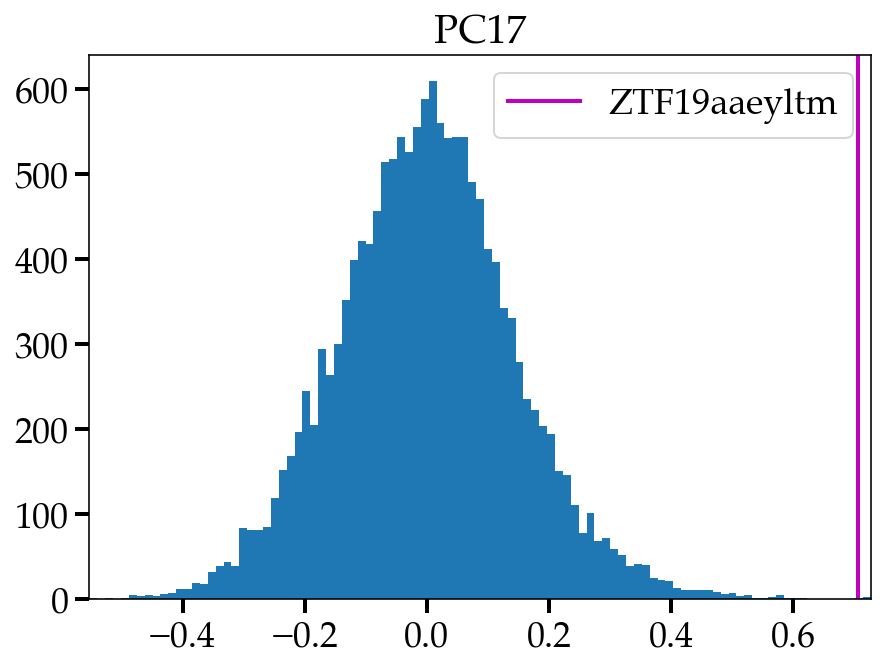

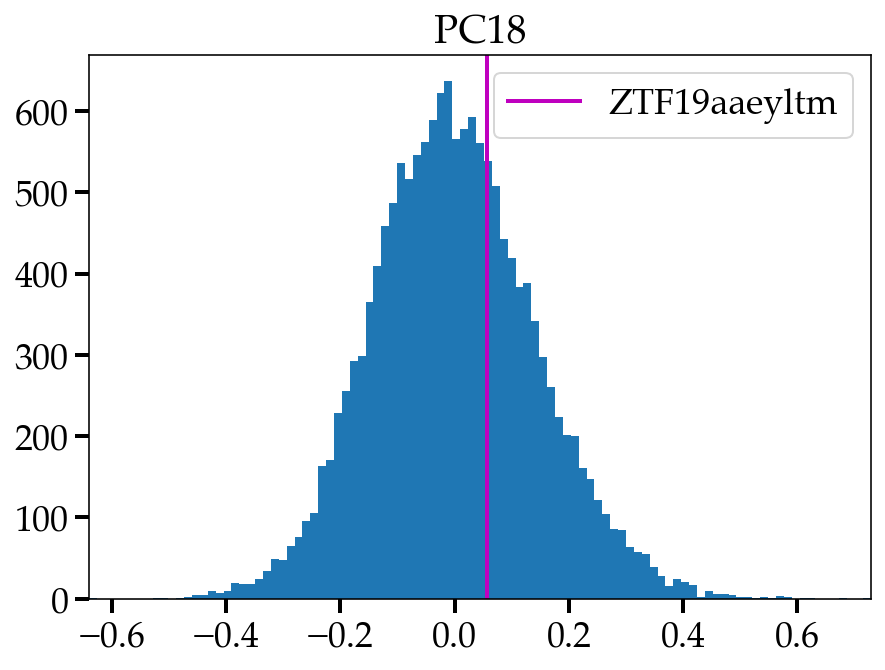

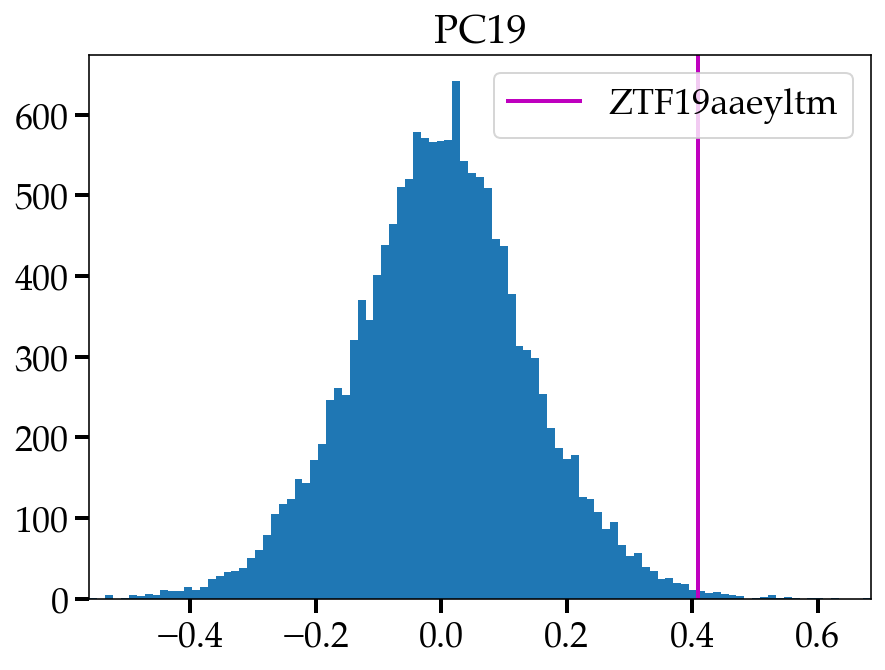

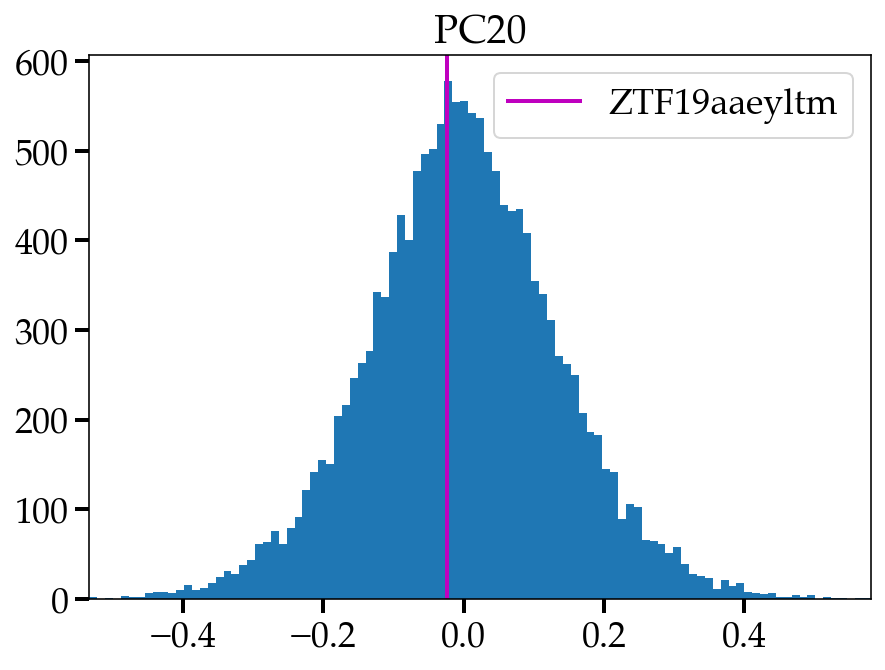

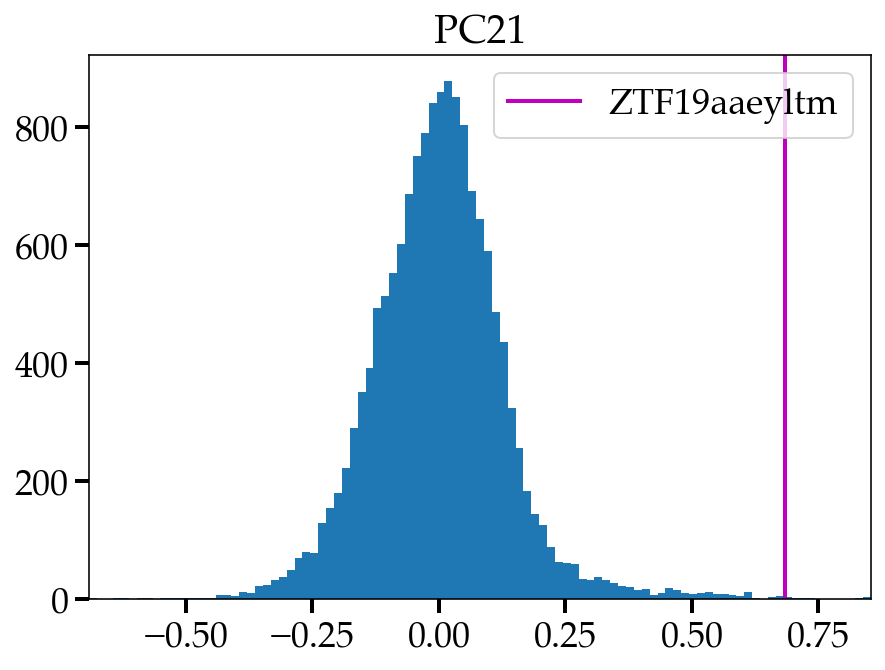

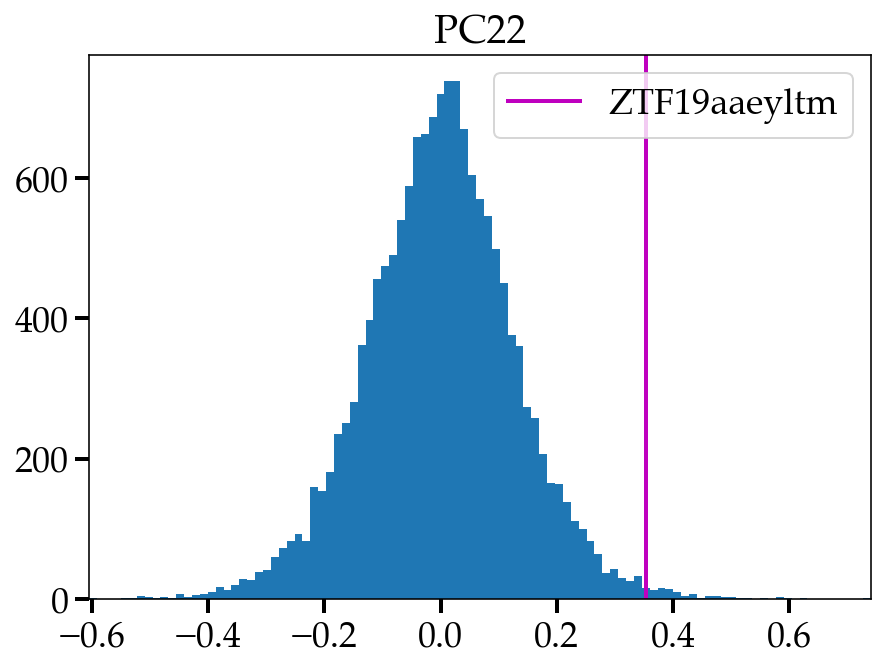

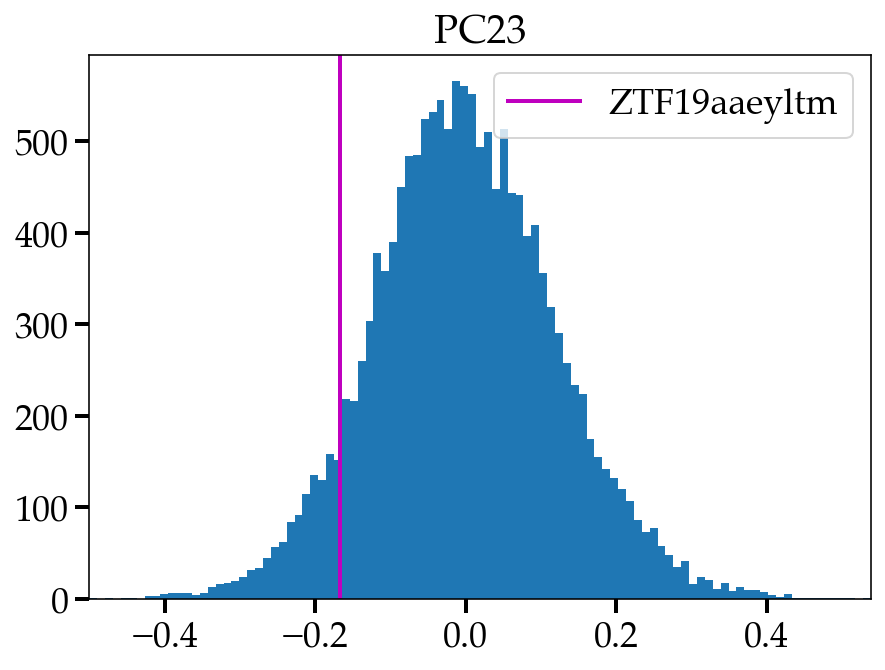

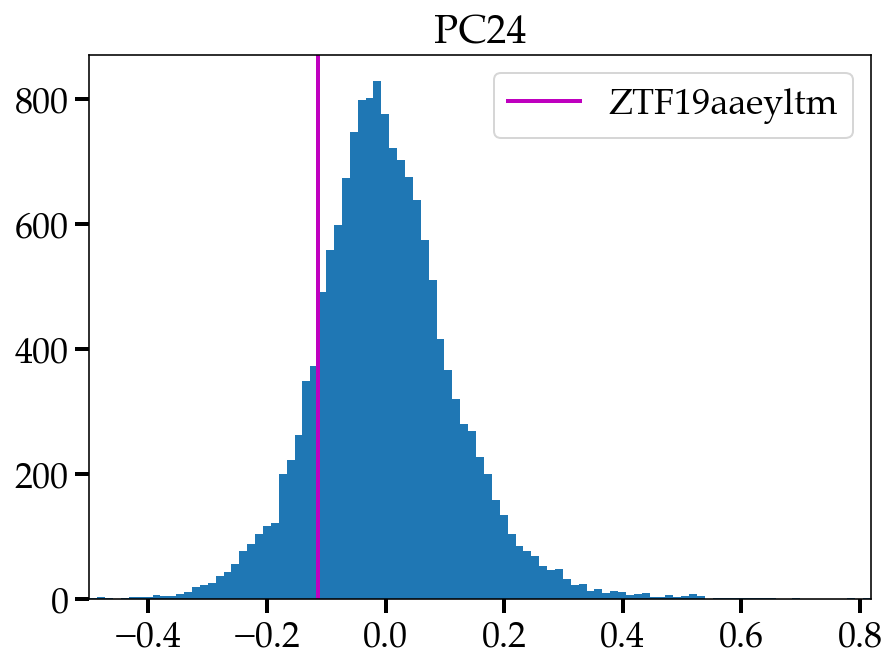

In [54]:
feat_scatter_l = []
for feat in dataset_bank.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(dataset_bank[feat], bins=np.linspace(min_feat, max_feat, 100))
    
    ref = dataset_bank[dataset_bank.index == ref_obj]
    
    ax.axvline(ref[feat].values[0], color='m', label=ref_obj)
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend()
    plt.show()
    
    feat_scatter = np.std(dataset_bank[feat])
    feat_scatter_l.append(feat_scatter)   

In [55]:
dataset_ref = dataset_bank[dataset_bank.index == ref_obj] #  ref_obj

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

# print(f"ZTF ID name (ref) {snid}") 
# link_ref = display_markdown(f'https://alerce.online/object/{snid}', raw=True)
# print(link_ref)
# print("%%%%%%")
# print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

print(f"ZTF ID name (ref) {snid}") 
link_ref = f'https://alerce.online/object/{snid}'
print(link_ref)
print("%%%%%%")
# print("ANN\t\tZTF_id\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
#     dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
#     print(f"{n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t\t{round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

#print("ANN\t\tZTF_id\t\t\t\tHas TNS?\t\t\t\tSpec Cls\t\t\t\tspecz\t\t\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    # host ra,dec
    ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
    
    # tns
    has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
    tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
    spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z
    
    print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

[-0.4264976041700145 1.3819498243698654 0.7606667414611703
 -0.48739372712654777 0.9860684414618474 0.418834367494246
 -0.5224100936559463 -0.08191765235533192 -0.020658762878280418
 0.33259726328616435 -0.06941420799512606 -0.4343756628779895
 0.2626120557890733 0.5977112969127507 -0.07318566392254722
 0.0636827484019195 0.11365004793582613 0.7057604342424847
 0.05620157255119185 0.4089020910000435 -0.023745297425135304
 0.683467151015185 0.3536698484073452 -0.1674451456703836
 -0.1145556127849583]
ZTF ID name (ref) ZTF19aaeyltm
https://alerce.online/object/ZTF19aaeyltm
%%%%%%
ANN=0	https://alerce.online/object/ZTF19aaeyltm		No_TNS		None		z=-99.0			d=0.0	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=164.00618542+57.11700351&filter=color

ANN=1	https://alerce.online/object/ZTF20acijzic		No_TNS		None		z=-99.0			d=1.6377	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=21.12828305+-15.53785961&filter=color

ANN=2	https://alerce.online/object/ZTF18ackwokk		No_TNS		None		z=-99.0			d=1

In [56]:
antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

In [57]:
# %%time

# ztf_id_ref = idx_arr[result_id[0]]
# ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
# df_ref = ref_info.timeseries.to_pandas()

# has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
# tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls

# fig, ax = plt.subplots(figsize=(7,7))
# #plt.gca().invert_yaxis()

# df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
# df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

# ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[0], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
#             label=f'REF: {ztf_id_ref}, d={round(result_dist[0], 3)}\n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}')
# ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[0], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
# #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1]-df_ref_r.ant_mag.min(), s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

# markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
# consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

# ztf_id_l = result_id[1:5]
# ztf_dist_l = result_dist[1:5]

# for num, loc in enumerate(ztf_id_l):
#     ztf_id_ann = idx_arr[ztf_id_l[num]]

#     l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
#     try:
#         df_knn = l_info.timeseries.to_pandas()
#     except: continue    
#     has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
#     tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
#     spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z

#     df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
#     df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]

#     ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[0], y=df_r.ant_mag.min()-df_r.ant_mag, yerr=df_r.ant_magerr, 
#                 fmt=markers[num], c='darkred', alpha=0.25, 
#                 label=f'ANN={num+1}: {ztf_id_ann}, d={round(ztf_dist_l[num], 3)}\n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}')
#     ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[0], y=df_g.ant_mag.min()-df_g.ant_mag, yerr=df_g.ant_magerr, 
#                 fmt=markers[num], c='darkgreen', alpha=0.25)
#     #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]-df_r.ant_mag.min(), s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

#     plt.ylabel('Apparent Mag. + Constant')
#     plt.xlabel('Days of event')
#     plt.xlim(-5, df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
#     plt.legend(frameon=False,
#                bbox_to_anchor=(1.00,0.53),
#                ncol=1)

#     plt.grid(True)
# plt.savefig(f'../figures/{ztf_id_ref}_ann={num+1}.jpg', dpi=150, bbox_inches='tight')

In [58]:
ann_dist_all_df.loc[ref_obj]

ann=0                  3677.000000
ann=1                 14151.000000
ann=2                  8849.000000
ann=3                  7628.000000
ann=4                  9648.000000
ann=5                 11737.000000
ann=6                  5658.000000
ann=7                 12057.000000
ann=8                  8660.000000
ann=9                  7577.000000
dist=0                    0.000000
dist=1                    1.637730
dist=2                    1.644236
dist=3                    1.652598
dist=4                    1.666530
dist=5                    1.692384
dist=6                    1.706920
dist=7                    1.725870
dist=8                    1.731963
dist=9                    1.761495
Mean-9ANNs                1.691081
WeightedMean-9ANNs        1.654041
Name: ZTF19aaeyltm, dtype: float64

In [59]:
# 100 largest distances
ann_dist_all_df[dist_col].nlargest(100)

key_0
ZTF19aaeyltm    1.654041
ZTF21acbalhp    1.620699
ZTF18abtteya    1.533787
ZTF21aaxntve    1.489783
ZTF18abvmlow    1.459188
                  ...   
ZTF20acjqkmg    1.068545
ZTF19aabymti    1.068404
ZTF18abuipdd    1.068049
ZTF18acyrxzd    1.067934
ZTF18abvtjgy    1.065562
Name: WeightedMean-9ANNs, Length: 100, dtype: float64

In [60]:
# 100 largest distances objs 
for ztfid in list(ann_dist_all_df[dist_col].nlargest(100).index):
    alerce_link = f'https://alerce.online/object/{ztfid}\n'
    print(alerce_link)

https://alerce.online/object/ZTF19aaeyltm

https://alerce.online/object/ZTF21acbalhp

https://alerce.online/object/ZTF18abtteya

https://alerce.online/object/ZTF21aaxntve

https://alerce.online/object/ZTF18abvmlow

https://alerce.online/object/ZTF20abfehpe

https://alerce.online/object/ZTF18abvbbvs

https://alerce.online/object/ZTF20abeywdn

https://alerce.online/object/ZTF20acqucpz

https://alerce.online/object/ZTF18aabjliz

https://alerce.online/object/ZTF21aaaadvr

https://alerce.online/object/ZTF21aaaodzf

https://alerce.online/object/ZTF20ablygyy

https://alerce.online/object/ZTF21aabpszb

https://alerce.online/object/ZTF18aaqvatw

https://alerce.online/object/ZTF18adbmbpa

https://alerce.online/object/ZTF18aaxuusk

https://alerce.online/object/ZTF19acxfjcy

https://alerce.online/object/ZTF18abwkzjq

https://alerce.online/object/ZTF19aamavcd

https://alerce.online/object/ZTF18aahkoar

https://alerce.online/object/ZTF18aapdhva

https://alerce.online/object/ZTF18achruvb

https://ale

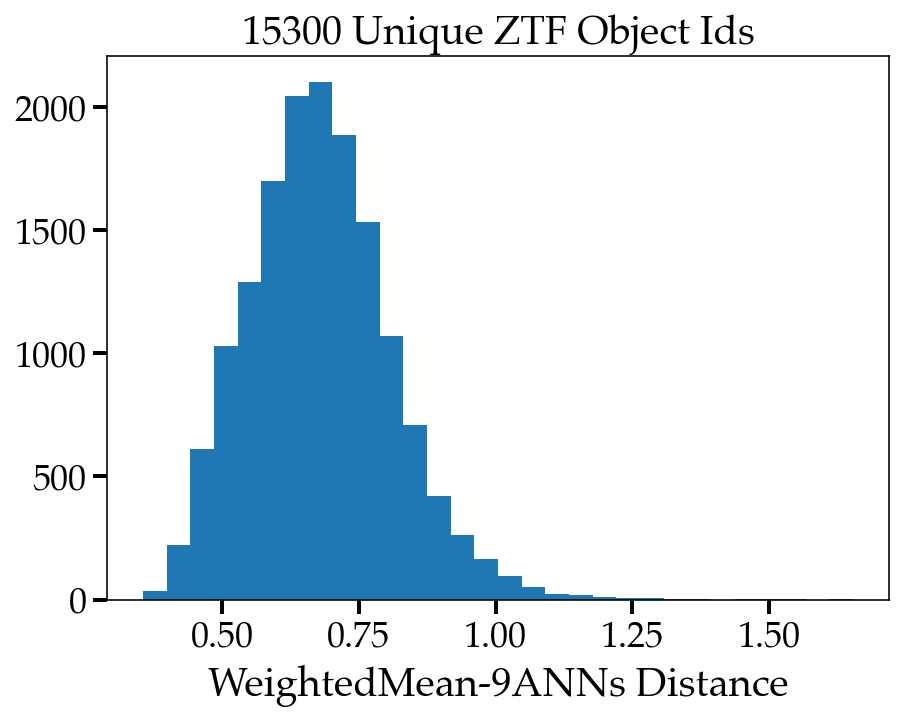

In [61]:
# 10 largest mean 9 ANN distances distances (most different)
plt.hist(ann_dist_all_df[dist_col], 
         bins=np.linspace(np.min(ann_dist_all_df[dist_col]), 
                          np.max(ann_dist_all_df[dist_col]), 31), density=False);
plt.xlabel(dist_col+' Distance');
#plt.yscale('log')
plt.title(f'{len(ann_dist_all_df)} Unique ZTF Object Ids');

In [62]:
print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df[dist_col]))
print("Scatter median:", np.median(ann_dist_all_df[dist_col]))
print("Scatter std:", np.std(ann_dist_all_df[dist_col]))
print("Scatter max:", np.max(ann_dist_all_df[dist_col]))
print("Scatter min:", np.min(ann_dist_all_df[dist_col]))
print("\n")

#Returns index of distance
print("Most anomalous:", ann_dist_all_df[[dist_col]].idxmax().values[0])

summary stats
Scatter mean: 0.6794310562905428
Scatter median: 0.6730227893726393
Scatter std: 0.13064085326272049
Scatter max: 1.6540414569052784
Scatter min: 0.35504047640345315


Most anomalous: ZTF19aaeyltm


# Smallest

### AGN/QSOs have smallest dist
### some stars, SN

In [63]:
ann_dist_all_df[dist_col].nsmallest(10)

key_0
ZTF19aalfali    0.355040
ZTF19aascqjr    0.363967
ZTF18acefnew    0.364640
ZTF21abowuqe    0.364673
ZTF19abpkoqf    0.364900
ZTF19aasfayj    0.376457
ZTF19abyhwmw    0.376885
ZTF21aarwlht    0.378201
ZTF18abixqaz    0.379555
ZTF17aaayial    0.380092
Name: WeightedMean-9ANNs, dtype: float64

In [64]:
# 10 smallest  distances (most similar)
for ztfid in list(ann_dist_all_df[dist_col].nsmallest(100).index):
    alerce_link = f'https://alerce.online/object/{ztfid}\n'
    print(alerce_link)

https://alerce.online/object/ZTF19aalfali

https://alerce.online/object/ZTF19aascqjr

https://alerce.online/object/ZTF18acefnew

https://alerce.online/object/ZTF21abowuqe

https://alerce.online/object/ZTF19abpkoqf

https://alerce.online/object/ZTF19aasfayj

https://alerce.online/object/ZTF19abyhwmw

https://alerce.online/object/ZTF21aarwlht

https://alerce.online/object/ZTF18abixqaz

https://alerce.online/object/ZTF17aaayial

https://alerce.online/object/ZTF19abkcmga

https://alerce.online/object/ZTF20abfphyf

https://alerce.online/object/ZTF19abjsfkq

https://alerce.online/object/ZTF18aaxwzcl

https://alerce.online/object/ZTF19abkfquy

https://alerce.online/object/ZTF20aawoixs

https://alerce.online/object/ZTF19abgfufo

https://alerce.online/object/ZTF19abctkyp

https://alerce.online/object/ZTF20abgbufk

https://alerce.online/object/ZTF20abnfjgj

https://alerce.online/object/ZTF18aceitok

https://alerce.online/object/ZTF18abxeckg

https://alerce.online/object/ZTF19acmvzsy

https://ale

In [65]:
dataset_ref = dataset_bank[dataset_bank.index == list(ann_dist_all_df[dist_col].nsmallest(10).index)[0]]

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

# print(f"ZTF ID name (ref) {snid}") 
# link_ref = display_markdown(f'https://alerce.online/object/{snid}', raw=True)
# print(link_ref)
# print("%%%%%%")
# print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

print(f"ZTF ID name (ref) {snid}") 
link_ref = f'https://alerce.online/object/{snid}'
print(link_ref)
print("%%%%%%")
# print("ANN\t\tZTF_id\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
#     dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
#     print(f"{n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t\t{round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    # host ra,dec
    ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
    
    # tns
    has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
    tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
    spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z
    
    print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

[0.4814920226609496 -0.022152092609850356 0.39680111948978114
 0.3834250237503911 -0.5263126459914067 -0.030779772198028483
 -0.10489151618216495 0.11375855729116283 0.4386952835324153
 0.41774698251303616 -0.0972186190963458 0.17226268755192464
 -0.024398112529264483 -0.004985476484699788 0.017369869688066152
 -0.040436426374818916 0.0880033799963554 0.027918784063423945
 0.0883914997519288 -0.01552781010081621 0.010708665940549974
 -0.037316507229898724 0.04247995550524933 -0.1075579858578789
 0.44306770133535495]
ZTF ID name (ref) ZTF19aalfali
https://alerce.online/object/ZTF19aalfali
%%%%%%
ANN=0	https://alerce.online/object/ZTF19aalfali		Yes_TNS		None		z=-99.0			d=0.0	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=267.06517947+55.23697266&filter=color

ANN=1	https://alerce.online/object/ZTF19aascqjr		No_TNS		None		z=-99.0			d=0.2603	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=218.41909158+60.96265845&filter=color

ANN=2	https://alerce.online/object/ZTF19aavkcfv		No_TNS		N

CPU times: user 2.06 s, sys: 89.3 ms, total: 2.15 s
Wall time: 5.64 s


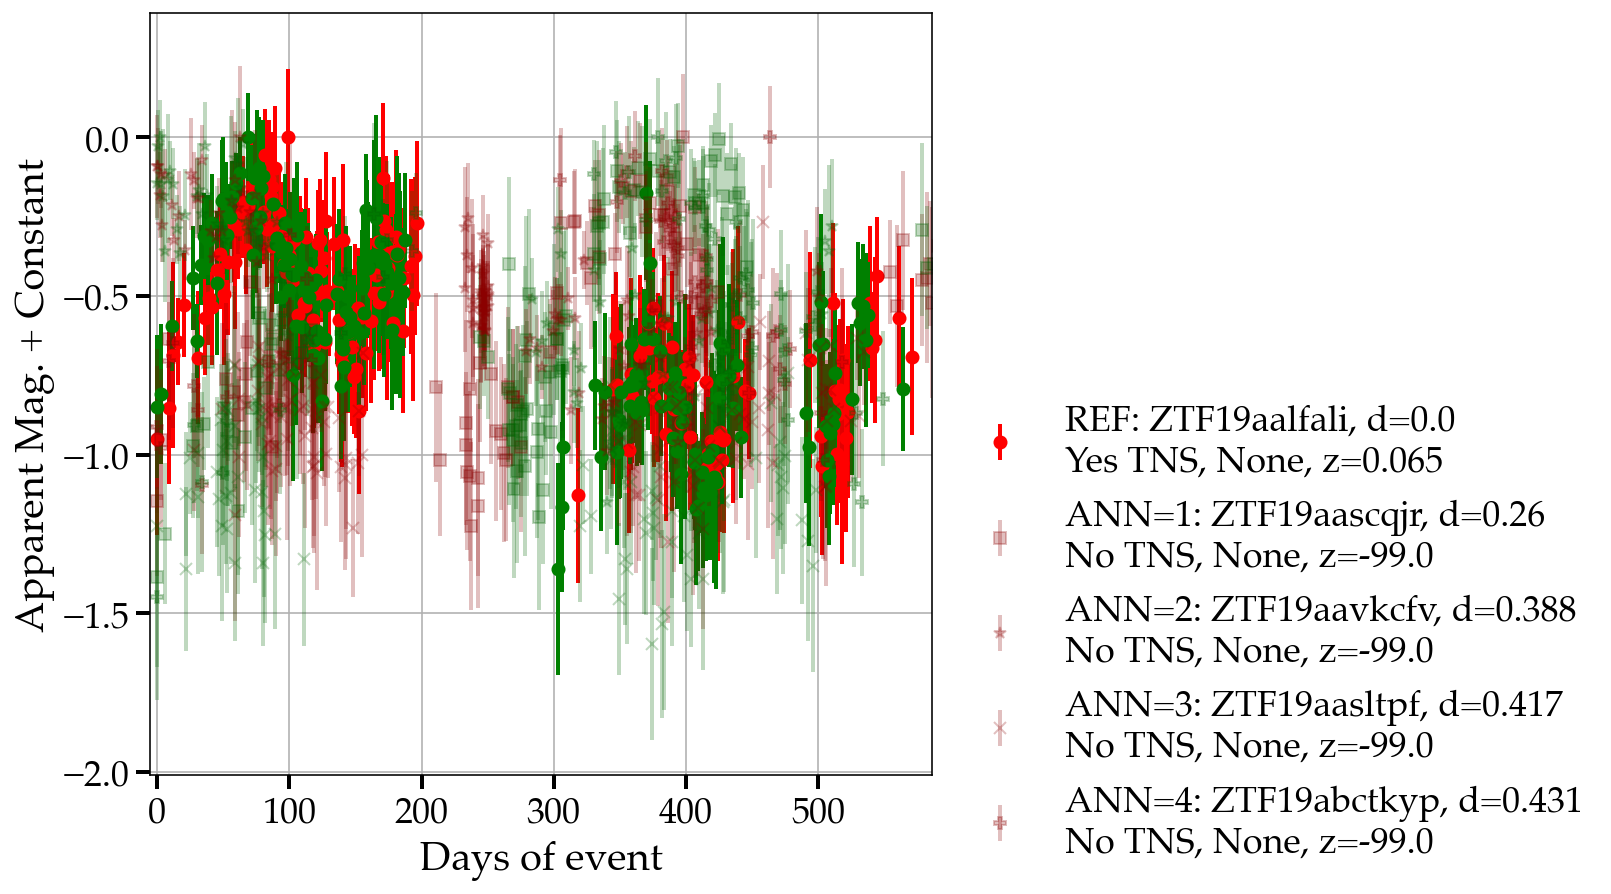

In [66]:
%%time

ztf_id_ref = idx_arr[result_id[0]]
ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[0], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
            label=f'REF: {ztf_id_ref}, d={round(result_dist[0], 3)}\n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[0], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
#ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1]-df_ref_r.ant_mag.min(), s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = result_id[1:5]
ztf_dist_l = result_dist[1:5]

for num, loc in enumerate(ztf_id_l):
    ztf_id_ann = idx_arr[ztf_id_l[num]]

    l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
    try:
        df_knn = l_info.timeseries.to_pandas()
    except: continue    
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z

    df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]

    ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[0], y=df_r.ant_mag.min()-df_r.ant_mag, yerr=df_r.ant_magerr, 
                fmt=markers[num], c='darkred', alpha=0.25, 
                label=f'ANN={num+1}: {ztf_id_ann}, d={round(ztf_dist_l[num], 3)}\n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}')
    ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[0], y=df_g.ant_mag.min()-df_g.ant_mag, yerr=df_g.ant_magerr, 
                fmt=markers[num], c='darkgreen', alpha=0.25)
    #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]-df_r.ant_mag.min(), s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

    plt.ylabel('Apparent Mag. + Constant')
    plt.xlabel('Days of event')
    plt.xlim(-5, df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    plt.legend(frameon=False,
               bbox_to_anchor=(1.00,0.53),
               ncol=1)

    plt.grid(True)
plt.savefig(f'../figures/{ztf_id_ref}_ann={num+1}.jpg', dpi=150, bbox_inches='tight')

In [ ]:
# dist ANN=1 and mean of first 9 ANN are roughly same (SN, CV, Mira, etc). 
# Not as many SN (but otherwise similar as above) in weighted (fibonacci) average of first 9 ANN.
# Separation will come down to host gal info

MaxAbsScaler, Euclidean, Ia

NON PCA
Scatter mean: 0.10822062189269697
Scatter median: 0.08390001702324312
Scatter std: 0.09273033952967297
Scatter max: 0.3615067063860504
Scatter min: 0.0

PCA
Scatter mean: 0.22748059656595504
Scatter median: 0.23485067052158148
Scatter std: 0.08590310140277316
Scatter max: 0.3552833440373228
Scatter min: 0.013447031738069838

MaxAbsScaler, Euclidean, SLSN

Scatter mean: 0.1882023265906344
Scatter median: 0.14632144856515017
Scatter std: 0.1839875260098897
Scatter max: 1.046586348913336
Scatter min: 0.006225538066605167

MaxAbsScaler, Euclidean, junk

Scatter mean: 0.18480675721201786
Scatter median: 0.14364864210180578
Scatter std: 0.208412667064402
Scatter max: 1.2017613918543555
Scatter min: 0.002740342445819787

# pandas profiling

In [105]:
ann_dist_all_tns_df = pd.concat([ann_dist_all_df, dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
ann_dist_all_tns_df = ann_dist_all_tns_df[~ann_dist_all_tns_df.isnull().any(axis=1)]

ann_dist_all_tns_df

,ann=0,ann=1,ann=2,ann=3,ann=4,ann=5,ann=6,ann=7,ann=8,ann=9,...,dist=6,dist=7,dist=8,dist=9,Mean-9ANNs,WeightedMean-9ANNs,has_tns,tns_cls,spec_z,report_group
ZTF17aaaazmz,9270,4192,10845,3554,14155,5249,13778,10107,13738,14386,...,0.785409,0.813500,0.814088,0.817577,0.759638,0.701585,No_TNS,None,-99.0,None
ZTF17aaabghb,7722,8338,10671,2010,11726,2260,13693,7514,11832,11733,...,0.656001,0.682243,0.682508,0.685925,0.624030,0.568223,No_TNS,None,-99.0,None
ZTF17aaabuab,13751,12692,2743,1948,2453,3868,5936,13717,6465,6671,...,0.799161,0.809077,0.810816,0.820227,0.783227,0.747659,No_TNS,None,-99.0,None
ZTF17aaaceht,2529,7553,14916,7966,9586,256,8439,10965,14471,7424,...,0.859365,0.878311,0.881507,0.884550,0.817628,0.736315,No_TNS,None,-99.0,None
ZTF17aaadqdy,5152,14450,11858,2734,6146,1491,11167,7790,10912,8767,...,0.852322,0.852990,0.867228,0.869649,0.831824,0.782426,No_TNS,None,-99.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acogvaq,8538,4402,3094,2775,10805,5758,13647,11400,4803,10862,...,0.764296,0.774567,0.790522,0.790801,0.723646,0.650970,No_TNS,None,-99.0,None
ZTF21acowflo,7520,7917,9282,4441,9514,10712,10335,9497,8213,11077,...,0.775421,0.777278,0.797512,0.806086,0.756945,0.709223,No_TNS,None,-99.0,None
ZTF21acqdfea,7770,1487,8129,9355,2912,8356,5049,1729,1147,4428,...,0.628519,0.639254,0.650825,0.667979,0.620416,0.590853,No_TNS,None,-99.0,None
ZTF21acqnurt,8033,5699,3777,4048,8568,11178,9341,11174,8859,7894,...,0.961169,0.974000,1.009872,1.019105,0.925953,0.861060,No_TNS,None,-99.0,None


In [106]:
ann_dist_all_tns_and_hosts_df_p1 = pd.concat([ann_dist_all_df.iloc[:,11:],
                                           dataset_bank_tns_and_hosts_df.iloc[:, 0:11],
                                           dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
ann_dist_all_tns_and_hosts_df_p1 = ann_dist_all_tns_and_hosts_df_p1[~ann_dist_all_tns_and_hosts_df_p1.isnull().any(axis=1)]

ann_dist_all_tns_and_hosts_df_p1

,dist=1,dist=2,dist=3,dist=4,dist=5,dist=6,dist=7,dist=8,dist=9,Mean-9ANNs,...,gPSFFlux,gApFlux,gKronFlux,gKronRad,gExtNSigma,rmomentXX,has_tns,tns_cls,spec_z,report_group
ZTF17aaaazmz,0.654275,0.684023,0.738692,0.755304,0.773870,0.785409,0.813500,0.814088,0.817577,0.759638,...,0.000022,0.000036,0.000035,3.51821,10.532400,0.254686,No_TNS,None,-99.0,None
ZTF17aaabghb,0.529915,0.561278,0.581126,0.585923,0.651349,0.656001,0.682243,0.682508,0.685925,0.624030,...,0.000027,0.000043,0.000044,4.06217,9.808500,0.288022,No_TNS,None,-99.0,None
ZTF17aaabuab,0.711802,0.740856,0.780917,0.785076,0.791114,0.799161,0.809077,0.810816,0.820227,0.783227,...,0.000030,0.000056,0.000056,3.96768,15.671700,0.237536,No_TNS,None,-99.0,None
ZTF17aaaceht,0.654410,0.736698,0.768126,0.836774,0.858914,0.859365,0.878311,0.881507,0.884550,0.817628,...,0.000003,0.000006,0.000007,3.41917,5.286480,0.264701,No_TNS,None,-99.0,None
ZTF17aaadqdy,0.703335,0.819508,0.823250,0.845888,0.852250,0.852322,0.852990,0.867228,0.869649,0.831824,...,0.000030,0.000081,0.000153,6.50138,33.167500,0.287254,No_TNS,None,-99.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acogvaq,0.577622,0.644418,0.706155,0.729304,0.735125,0.764296,0.774567,0.790522,0.790801,0.723646,...,0.000019,0.000038,0.000039,3.84154,15.055400,0.185502,No_TNS,None,-99.0,None
ZTF21acowflo,0.648340,0.718851,0.757951,0.759687,0.771375,0.775421,0.777278,0.797512,0.806086,0.756945,...,0.000003,0.000006,0.000007,3.67332,3.683880,0.249079,No_TNS,None,-99.0,None
ZTF21acqdfea,0.569961,0.585191,0.597237,0.618849,0.625929,0.628519,0.639254,0.650825,0.667979,0.620416,...,0.000010,0.000023,0.000026,4.15479,15.726700,0.289378,No_TNS,None,-99.0,None
ZTF21acqnurt,0.814230,0.863586,0.872981,0.883910,0.934729,0.961169,0.974000,1.009872,1.019105,0.925953,...,0.000003,0.000004,0.000004,2.81373,3.489210,0.245337,No_TNS,None,-99.0,None


In [109]:
ann_dist_all_tns_and_lcfeats_df_p1 = pd.concat([ann_dist_all_df.iloc[:,20:],
                                           dataset_bank_tns_and_lcfeats_df.iloc[:, 0:21],
                                           dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
ann_dist_all_tns_and_lcfeats_df_p1 = ann_dist_all_tns_and_lcfeats_df_p1[~ann_dist_all_tns_and_lcfeats_df_p1.isnull().any(axis=1)]

ann_dist_all_tns_and_lcfeats_df_p1

,Mean-9ANNs,WeightedMean-9ANNs,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,...,feature_mean_magn_r,feature_median_absolute_deviation_magn_r,feature_percent_amplitude_magn_r,feature_median_buffer_range_percentage_10_magn_r,feature_median_buffer_range_percentage_20_magn_r,feature_percent_difference_magnitude_percentile_5_magn_r,has_tns,tns_cls,spec_z,report_group
ZTF17aaaazmz,0.759638,0.701585,1.171598,-0.125017,0.229508,0.181071,0.230875,2.106324,0.937863,0.545249,...,16.556838,0.266766,1.538268,0.180328,0.442623,-1.099501,No_TNS,None,-99.0,None
ZTF17aaabghb,0.624030,0.568223,0.362954,-0.653712,0.444444,0.000000,0.334459,0.725908,0.667269,0.384046,...,17.468898,0.170258,0.452400,0.111111,0.222222,-1.380266,No_TNS,None,-99.0,None
ZTF17aaabuab,0.783227,0.747659,0.320659,-0.848917,0.400000,0.000000,0.398610,0.641317,0.641317,0.420801,...,19.224922,0.226124,0.377937,0.200000,0.200000,-1.477782,No_TNS,None,-99.0,None
ZTF17aaaceht,0.817628,0.736315,0.898299,-0.234235,0.111111,0.333333,0.275632,1.796598,1.508999,0.659100,...,19.471912,0.277000,1.390999,0.111111,0.333333,-1.031722,No_TNS,None,-99.0,None
ZTF17aaadqdy,0.831824,0.782426,0.851705,-0.215799,0.222222,0.000000,0.236139,1.703409,1.438321,0.733250,...,17.685125,0.350174,1.011350,0.111111,0.166667,-1.044432,No_TNS,None,-99.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acogvaq,0.723646,0.650970,0.208000,-1.031033,0.500000,0.000000,0.400851,0.416000,0.416000,0.299950,...,20.361325,0.130300,0.247351,0.000000,0.000000,-1.689292,No_TNS,None,-99.0,None
ZTF21acowflo,0.756945,0.709223,1.043352,0.176584,0.413793,0.000000,0.337711,2.075553,1.568862,1.239904,...,16.328181,0.353545,1.591955,0.137931,0.275862,-0.913211,No_TNS,None,-99.0,None
ZTF21acqdfea,0.620416,0.590853,1.103750,-0.195983,0.314286,0.239046,0.177260,2.062999,1.245758,0.804867,...,16.273750,0.404491,1.155310,0.142857,0.285714,-1.055520,No_TNS,None,-99.0,None
ZTF21acqnurt,0.925953,0.861060,1.511355,-0.366659,0.285714,0.000000,0.357832,3.022711,2.650330,0.905899,...,16.540213,0.115768,1.807098,0.571429,0.571429,-0.732146,No_TNS,None,-99.0,None


In [111]:
ann_dist_all_tns_and_lcfeats_df_p2 = pd.concat([ann_dist_all_df.iloc[:,20:],
                                           dataset_bank_tns_and_lcfeats_df.iloc[:, 21:41],
                                           dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
ann_dist_all_tns_and_lcfeats_df_p2 = ann_dist_all_tns_and_lcfeats_df_p2[~ann_dist_all_tns_and_lcfeats_df_p2.isnull().any(axis=1)]

ann_dist_all_tns_and_lcfeats_df_p2

,Mean-9ANNs,WeightedMean-9ANNs,feature_percent_difference_magnitude_percentile_10_magn_r,feature_period_s_to_n_0_magn_r,feature_period_s_to_n_1_magn_r,feature_period_s_to_n_2_magn_r,feature_period_s_to_n_3_magn_r,feature_period_s_to_n_4_magn_r,feature_periodogram_beyond_2_std_magn_r,feature_periodogram_beyond_3_std_magn_r,...,feature_cusum_flux_r,feature_excess_variance_flux_r,feature_kurtosis_flux_r,feature_mean_variance_flux_r,feature_skew_flux_r,feature_stetson_k_flux_r,has_tns,tns_cls,spec_z,report_group
ZTF17aaaazmz,0.759638,0.701585,-1.246568,2.179178,1.933757,1.855695,1.721224,1.688221,0.051758,0.010742,...,0.163459,0.644882,3.398174,-0.276715,1.919718,0.698179,No_TNS,None,-99.0,None
ZTF17aaabghb,0.624030,0.568223,-1.416847,1.344333,1.333010,1.328976,1.289912,1.243621,0.000000,0.000000,...,0.334946,0.352048,-1.032664,-0.649081,-0.024215,0.885969,No_TNS,None,-99.0,None
ZTF17aaabuab,0.783227,0.747659,-1.477782,1.488277,1.323163,1.001883,0.864970,0.854680,0.031250,0.000000,...,0.403249,0.331518,-1.108242,-0.618436,0.484792,0.897765,No_TNS,None,-99.0,None
ZTF17aaaceht,0.817628,0.736315,-1.107485,1.612419,1.465911,1.434218,1.241284,0.396805,0.039062,0.000000,...,0.296769,0.529283,-0.473225,-0.390193,-0.510199,0.811533,No_TNS,None,-99.0,None
ZTF17aaadqdy,0.831824,0.782426,-1.091772,1.932848,1.839446,1.688019,1.651416,1.474735,0.054688,0.011719,...,0.243337,0.660847,0.271299,-0.266194,1.018892,0.776695,No_TNS,None,-99.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acogvaq,0.723646,0.650970,-1.689292,1.403898,1.316485,1.123045,0.248722,-0.249409,0.000000,0.000000,...,0.404531,-0.298504,-1.701132,-0.773452,-0.248027,0.919410,No_TNS,None,-99.0,None
ZTF21acowflo,0.756945,0.709223,-1.008615,2.177635,1.889092,1.746470,1.722375,1.587684,0.056641,0.009766,...,0.338253,0.632475,-1.196776,-0.296881,-0.073477,0.892801,No_TNS,None,-99.0,None
ZTF21acqdfea,0.620416,0.590853,-1.115018,2.050165,1.911864,1.884375,1.830220,1.639242,0.064453,0.017578,...,0.199073,0.582217,1.312167,-0.348924,0.781445,0.732016,No_TNS,None,-99.0,None
ZTF21acqnurt,0.925953,0.861060,-0.789242,1.460312,1.448992,1.435716,1.250504,1.178680,0.015625,0.000000,...,0.300044,0.897105,2.155695,-0.069748,1.369929,0.770503,No_TNS,None,-99.0,None


import pandas_profiling as pp
profile = pp.ProfileReport(ann_dist_all_tns_and_lcfeats_df_p2)
#profile = pp.ProfileReport(dataset_bank_tns_df)
#profile.to_file("output.html")
profile.to_file("ann_dist_all_tns_and_lcfeats_df_p2.html")

import pandas_profiling as pp
profile = pp.ProfileReport(dataset_bank_orig[0:1000])
#profile = pp.ProfileReport(dataset_bank_tns_df)
#profile.to_file("output.html")
profile.to_file("dataset_bank_orig.html")

In [ ]:
# %%time

# ztf_id_ref = idx_arr[result_id[0]]
# ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
# df_ref = ref_info.timeseries.to_pandas()

# has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
# tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls

# fig, ax = plt.subplots(figsize=(7,11))
# plt.gca().invert_yaxis()

# df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
# df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

# ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[0], y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', label=f'ref {ztf_id_ref}')
# ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[0], y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
# ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1], s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

# markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
# consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

# ztf_id_l = result_id[1:8]
# ztf_dist_l = result_dist[1:8]

# for num, loc in enumerate(ztf_id_l):
#     ztf_id_ann = idx_arr[ztf_id_l[num]]

#     l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
#     try:
#         df_knn = l_info.timeseries.to_pandas()
#     except: continue    
#     has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
#     tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls

#     df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
#     df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]

#     ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[0], y=df_r.ant_mag+consts[num], yerr=df_r.ant_magerr, 
#                 fmt=markers[num], c='darkred', alpha=0.5, label=f'ANN={num+1} {ztf_id_ann} d={round(ztf_dist_l[num], 3)}')
#     ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[0], y=df_g.ant_mag+consts[num], yerr=df_g.ant_magerr, 
#                 fmt=markers[num], c='darkgreen', alpha=0.5)
#     ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]+consts[num], s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

#     plt.ylabel('Apparent Mag. + Constant')
#     plt.xlabel('Days of event')
#     plt.xlim(-5, df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+50)
#     plt.legend(frameon=False,
#                bbox_to_anchor=(1.00,0.98),
#                ncol=1)

#     plt.grid(True)
# #plt.savefig(f'./LAISS_figures/{ztf_id_ref}_knn={num+1}.png', dpi=300, bbox_inches='tight')